<a href="https://colab.research.google.com/github/kartikshrma/electroencephalogram/blob/main/eegdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d youssefkead/liewaves-truth-lie

Dataset URL: https://www.kaggle.com/datasets/youssefkead/liewaves-truth-lie
License(s): apache-2.0
  0% 0.00/16.0M [00:00<?, ?B/s]
100% 16.0M/16.0M [00:00<00:00, 960MB/s]


In [4]:
!unzip liewaves-truth-lie.zip

Archive:  liewaves-truth-lie.zip
  inflating: Lie_Sessions/4_ATAR/S10S2.csv  
  inflating: Lie_Sessions/4_ATAR/S11S2.csv  
  inflating: Lie_Sessions/4_ATAR/S12S2.csv  
  inflating: Lie_Sessions/4_ATAR/S13S2.csv  
  inflating: Lie_Sessions/4_ATAR/S14S1.csv  
  inflating: Lie_Sessions/4_ATAR/S15S2.csv  
  inflating: Lie_Sessions/4_ATAR/S16S2.csv  
  inflating: Lie_Sessions/4_ATAR/S17S2.csv  
  inflating: Lie_Sessions/4_ATAR/S18S2.csv  
  inflating: Lie_Sessions/4_ATAR/S19S2.csv  
  inflating: Lie_Sessions/4_ATAR/S1S2.csv  
  inflating: Lie_Sessions/4_ATAR/S20S2.csv  
  inflating: Lie_Sessions/4_ATAR/S21S2.csv  
  inflating: Lie_Sessions/4_ATAR/S22S1.csv  
  inflating: Lie_Sessions/4_ATAR/S23S2.csv  
  inflating: Lie_Sessions/4_ATAR/S24S2.csv  
  inflating: Lie_Sessions/4_ATAR/S25S1.csv  
  inflating: Lie_Sessions/4_ATAR/S26S1.csv  
  inflating: Lie_Sessions/4_ATAR/S27S2.csv  
  inflating: Lie_Sessions/4_ATAR/S2S2.csv  
  inflating: Lie_Sessions/4_ATAR/S3S2.csv  
  inflating: Lie_Sessions

In [5]:
%ls

Lie_Sessions/  liewaves-truth-lie.zip  sample_data/  Truth_Sessions/


In [6]:
!ls Lie_Sessions/
!ls Truth_Sessions/

4_ATAR	Raw
4_ATAR	Raw


In [7]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

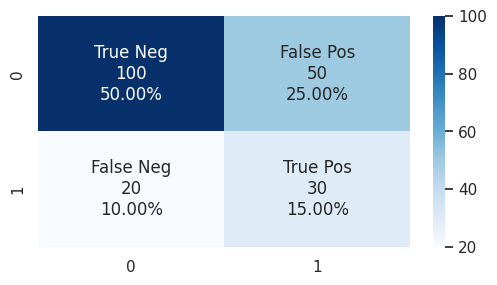

In [8]:
import numpy as np
def confusionMatrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.set(rc={'figure.figsize':(6,3)})
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# sample matrix
sample_cf_matrix = np.array([[100, 50], [20, 30]])
confusionMatrix(sample_cf_matrix)

In [9]:
import os

lie_dir = 'Lie_Sessions'
truth_dir = 'Truth_Sessions'

lie_dfs = []
truth_dfs = []

In [10]:
for subdir, _, files in os.walk(lie_dir):
    for file in files:
        if file.endswith('.csv'):
            filepath = os.path.join(subdir, file)
            try:
                df = pd.read_csv(filepath)
                lie_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not read file {filepath}. Error: {e}")


In [11]:
for subdir, _, files in os.walk(truth_dir):
    for file in files:
        if file.endswith('.csv'):
            filepath = os.path.join(subdir, file)
            try:
                df = pd.read_csv(filepath)
                truth_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not read file {filepath}. Error: {e}")


Concatenate the dataframes in the lie_dfs and truth_dfs lists into two separate dataframes.



In [12]:
lie_df = pd.concat(lie_dfs, ignore_index=True)
truth_df = pd.concat(truth_dfs, ignore_index=True)

In [13]:
lie_df['label'] = 0
truth_df['label'] = 1

In [14]:
df = pd.concat([lie_df, truth_df], ignore_index=True)
display(df.head())
display(df.info())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label
0,-3.27896,3.39273,-1.66600,3.04548,-9.85480,0
1,-7.24583,3.40071,-5.21758,3.65748,-21.45931,0
2,-3.72066,-1.52956,-6.32967,-4.02812,-13.28163,0
3,-1.34322,1.09462,-3.10499,-6.57486,-7.40745,0
4,-10.03219,-2.63313,-7.97089,-9.14305,-22.96134,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036800 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   EEG.AF3  1036800 non-null  float64
 1   EEG.T7   1036800 non-null  float64
 2   EEG.Pz   1036800 non-null  float64
 3   EEG.T8   1036800 non-null  float64
 4   EEG.AF4  1036800 non-null  float64
 5   label    1036800 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 47.5 MB


None

In [15]:
display(df.head())
display(df.info())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label
0,-3.27896,3.39273,-1.66600,3.04548,-9.85480,0
1,-7.24583,3.40071,-5.21758,3.65748,-21.45931,0
2,-3.72066,-1.52956,-6.32967,-4.02812,-13.28163,0
3,-1.34322,1.09462,-3.10499,-6.57486,-7.40745,0
4,-10.03219,-2.63313,-7.97089,-9.14305,-22.96134,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036800 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   EEG.AF3  1036800 non-null  float64
 1   EEG.T7   1036800 non-null  float64
 2   EEG.Pz   1036800 non-null  float64
 3   EEG.T8   1036800 non-null  float64
 4   EEG.AF4  1036800 non-null  float64
 5   label    1036800 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 47.5 MB


None

In [16]:
from scipy.signal import butter, filtfilt

# Define filter parameters
lowcut = 0.5  # Hz
highcut = 30.0 # Hz
fs = 256
order = 5

nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# filter to each EEG channel
eeg_channels = ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']
for channel in eeg_channels:
    df[channel] = filtfilt(b, a, df[channel])

display(df.head())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label
0,-6.678970,-5.603982,-4.134092,-7.349410,-11.427159,0
1,-7.540931,-6.755299,-5.921086,-10.887096,-14.325380,0
2,-8.485796,-8.253963,-7.980483,-14.105294,-17.184845,0
3,-9.452527,-10.240629,-10.363773,-16.681239,-19.827309,0
4,-10.186851,-12.530167,-12.797178,-18.335232,-21.905224,0


In [17]:
threshold = 3

eeg_channels = ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']
for channel in eeg_channels:
    # mean and standard deviation for the channel
    mean = df[channel].mean()
    std = df[channel].std()

    # data points exceeding the threshold
    artifact_mask = (np.abs(df[channel] - mean) > threshold * std)

    if df[artifact_mask].shape[0] > 0:
        print(f"Warning: {df[artifact_mask].shape[0]} potential artifacts found in {channel}. Removing corresponding rows.")
        df = df[~artifact_mask]


display(df.head())
display(df.info())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label
0,-6.678970,-5.603982,-4.134092,-7.349410,-11.427159,0
1,-7.540931,-6.755299,-5.921086,-10.887096,-14.325380,0
2,-8.485796,-8.253963,-7.980483,-14.105294,-17.184845,0
3,-9.452527,-10.240629,-10.363773,-16.681239,-19.827309,0
4,-10.186851,-12.530167,-12.797178,-18.335232,-21.905224,0


<class 'pandas.core.frame.DataFrame'>
Index: 967642 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   EEG.AF3  967642 non-null  float64
 1   EEG.T7   967642 non-null  float64
 2   EEG.Pz   967642 non-null  float64
 3   EEG.T8   967642 non-null  float64
 4   EEG.AF4  967642 non-null  float64
 5   label    967642 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 51.7 MB


None

In [18]:
# Splitting data into features (X) and target variable (y)
X = df.drop('label', axis=1)
y = df['label']

display(X.head())
display(y.head())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4
0,-6.678970,-5.603982,-4.134092,-7.349410,-11.427159
1,-7.540931,-6.755299,-5.921086,-10.887096,-14.325380
2,-8.485796,-8.253963,-7.980483,-14.105294,-17.184845
3,-9.452527,-10.240629,-10.363773,-16.681239,-19.827309
4,-10.186851,-12.530167,-12.797178,-18.335232,-21.905224


,label
0,0
1,0
2,0
3,0
4,0


In [19]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (774113, 5)
Shape of X_test: (193529, 5)
Shape of y_train: (774113,)
Shape of y_test: (193529,)


In [20]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

display(X_train_scaled_df.head())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4
594487,-0.506243,-1.036482,-0.693915,-1.259258,-0.643547
830398,0.299699,2.015622,1.508864,1.546700,1.550234
254720,0.668625,-0.071006,0.305430,0.359338,0.608407
558553,0.131285,-0.125811,-0.184231,-0.080304,0.393795
413365,1.074250,1.177263,1.654470,2.959451,0.285879


In [21]:
# time-domain features: mean and standard deviation across channels for each row
df['EEG_mean_across_channels'] = df[['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']].mean(axis=1)
df['EEG_std_across_channels'] = df[['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']].std(axis=1)

display(df.head())
display(df.info())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label,EEG_mean_across_channels,EEG_std_across_channels
0,-6.678970,-5.603982,-4.134092,-7.349410,-11.427159,0,-7.038722,2.737685
1,-7.540931,-6.755299,-5.921086,-10.887096,-14.325380,0,-9.085958,3.483214
2,-8.485796,-8.253963,-7.980483,-14.105294,-17.184845,0,-11.202076,4.203285
3,-9.452527,-10.240629,-10.363773,-16.681239,-19.827309,0,-13.313095,4.658914
4,-10.186851,-12.530167,-12.797178,-18.335232,-21.905224,0,-15.150930,4.816920


<class 'pandas.core.frame.DataFrame'>
Index: 967642 entries, 0 to 1036799
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   EEG.AF3                   967642 non-null  float64
 1   EEG.T7                    967642 non-null  float64
 2   EEG.Pz                    967642 non-null  float64
 3   EEG.T8                    967642 non-null  float64
 4   EEG.AF4                   967642 non-null  float64
 5   label                     967642 non-null  int64  
 6   EEG_mean_across_channels  967642 non-null  float64
 7   EEG_std_across_channels   967642 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 66.4 MB


None

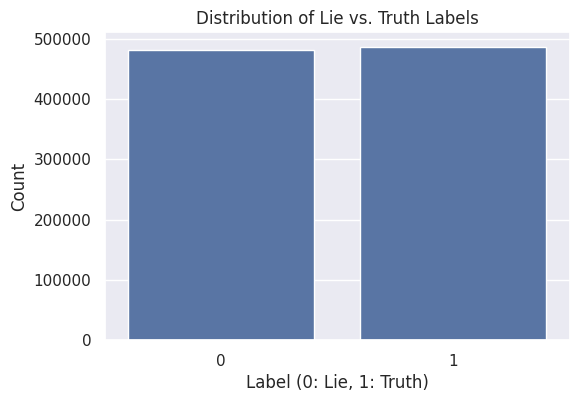

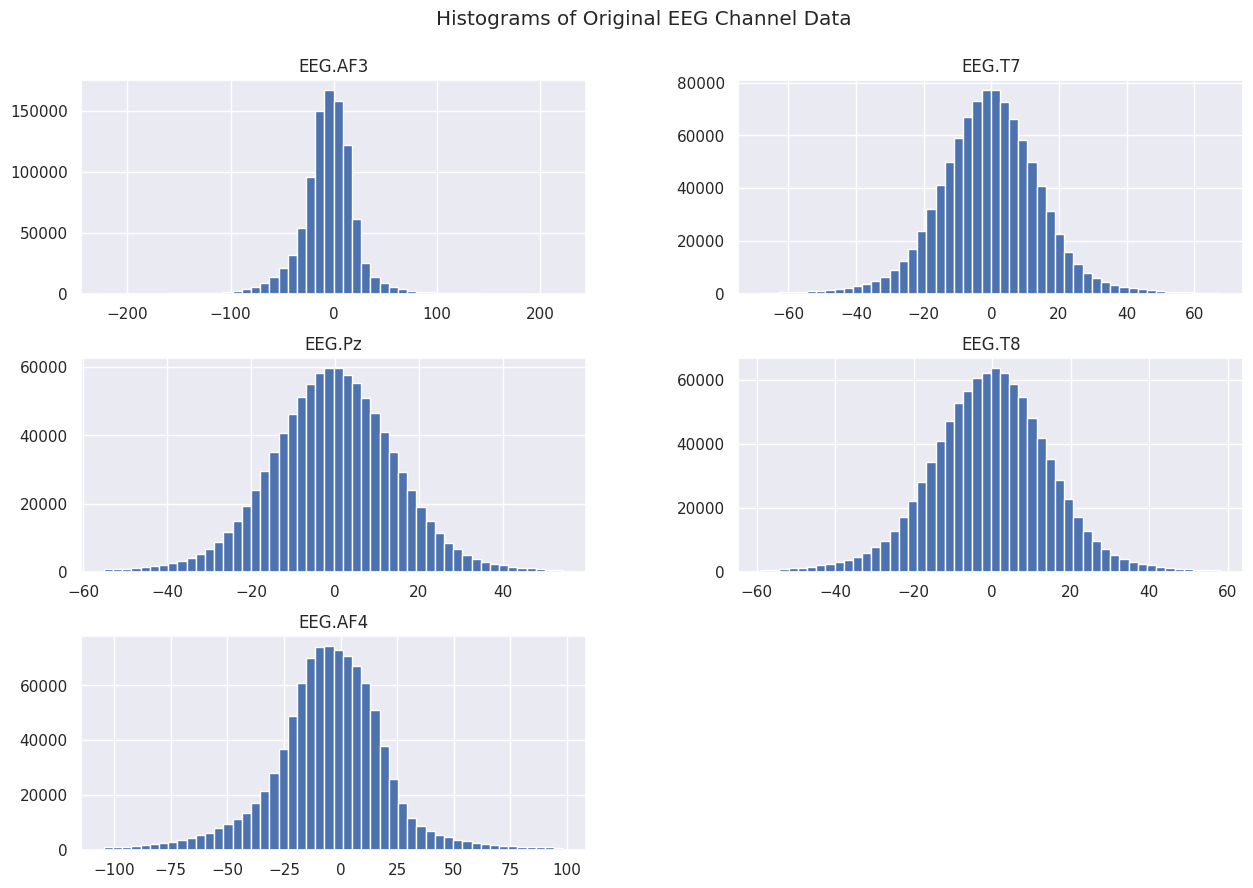

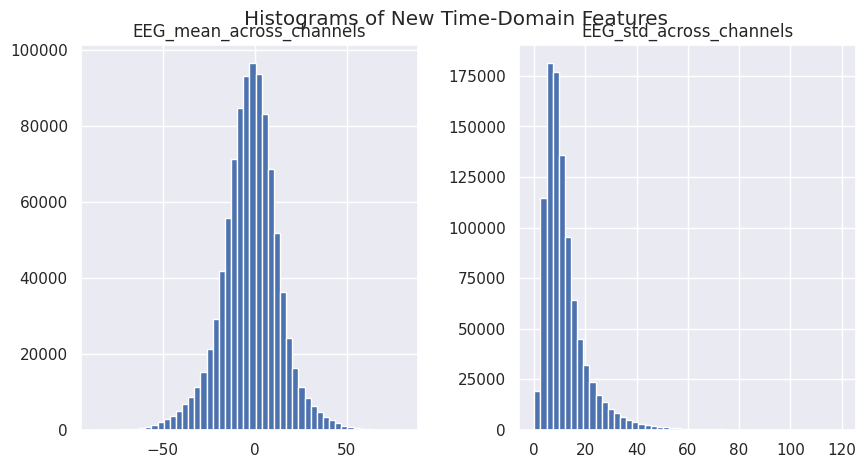

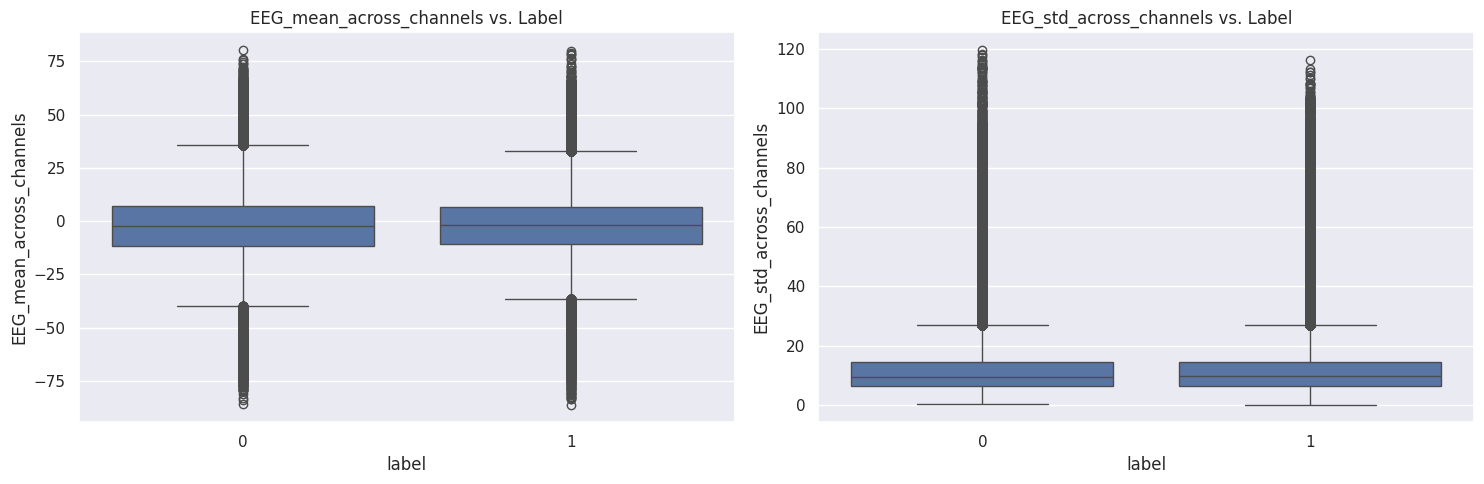

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Lie vs. Truth Labels')
plt.xlabel('Label (0: Lie, 1: Truth)')
plt.ylabel('Count')
plt.show()

# distribution of the original EEG features
eeg_channels = ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']
df[eeg_channels].hist(bins=50, figsize=(15, 10))
plt.suptitle('Histograms of Original EEG Channel Data', y=0.95)
plt.show()

# distribution of the new time-domain features
new_features = ['EEG_mean_across_channels', 'EEG_std_across_channels']
df[new_features].hist(bins=50, figsize=(10, 5))
plt.suptitle('Histograms of New Time-Domain Features', y=0.95)
plt.show()

# relationships between features and label
plt.figure(figsize=(15, 5))
for i, feature in enumerate(new_features):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'{feature} vs. Label')
plt.tight_layout()
plt.show()


Applying PCA to the scaled training data and transform both training and testing data.



In [23]:
from sklearn.decomposition import PCA

# PCA, retaining 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data
pca.fit(X_train_scaled)

# both scaled training and testing data
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)

# variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained variance ratio by each component:", explained_variance_ratio)
print("Total explained variance:", np.sum(explained_variance_ratio))

Shape of X_train after PCA: (774113, 4)
Shape of X_test after PCA: (193529, 4)

Explained variance ratio by each component: [0.60583924 0.19502061 0.10145085 0.06764327]
Total explained variance: 0.9699539638436038



Converting the PCA-transformed numpy arrays into pandas DataFrames with appropriate column names and display their head and shape to verify the transformation.



In [24]:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])], index=X_train.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])], index=X_test.index)

print("Shape of X_train_pca_df:", X_train_pca_df.shape)
print("Shape of X_test_pca_df:", X_test_pca_df.shape)

display(X_train_pca_df.head())
display(X_test_pca_df.head())

Shape of X_train_pca_df: (774113, 4)
Shape of X_test_pca_df: (193529, 4)


,PC1,PC2,PC3,PC4
594487,-1.840585,0.484281,-0.030807,0.434439
830398,3.075050,-0.977551,0.376948,-0.208617
254720,0.858897,0.477061,-0.271701,0.047803
558553,0.075008,0.420549,-0.003067,-0.061734
413365,3.188712,-1.306052,-0.920113,-0.798759


,PC1,PC2,PC3,PC4
324179,1.313086,-0.584526,-0.592764,0.519453
491229,1.827705,1.750679,0.476409,0.379679
666886,0.113081,0.405017,0.378670,-0.337724
186561,0.088612,0.015426,-0.324682,-0.096839
261471,-0.444091,1.292687,-0.932936,-0.684056


PCA was applied to the scaled training data, reducing the dimensionality from the original number of features to 4 principal components while retaining approximately 96.99% of the total variance, exceeding the target of 95%.
* The PCA-transformed training data has a shape of (774113, 4), and the transformed testing data has a shape of (193529, 4).
* The explained variance ratio for the 4 components shows how the variance is distributed: the first component explains the largest proportion, followed by the subsequent components.
* The PCA-transformed data was successfully converted into pandas DataFrames with column names 'PC1' through 'PC4', making it suitable for machine learning model input.

The dimensionality reduction achieved by PCA significantly reduces the number of features, which should help mitigate the curse of dimensionality and potentially improve model training efficiency.
*   The next step is to train a machine learning model using the PCA-transformed training data and evaluate its performance on the PCA-transformed testing data to assess the impact of dimensionality reduction on model performance.


In [25]:
# Initialize the base learner models
lr_model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier()
svm_model = svm.SVC()
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss') # Suppress deprecation warning

# Train each model
print("Training Logistic Regression...")
lr_model.fit(X_train_pca_df, y_train)
print("Logistic Regression training complete.")

print("Training K-Nearest Neighbors...")
knn_model.fit(X_train_pca_df, y_train)
print("K-Nearest Neighbors training complete.")

print("Training Decision Tree...")
dt_model.fit(X_train_pca_df, y_train)
print("Decision Tree training complete.")

print("Training Support Vector Machine...")
# Due to the large dataset size, training SVM with default parameters might be computationally expensive.
# For demonstration purposes, we'll fit on a smaller subset or note this limitation.
# Let's fit on a subset for now to avoid extremely long execution time.
# If full data training is needed, consider using optimized SVM implementations or different kernels.
subset_size = 50000  # Adjust subset size as needed
svm_model.fit(X_train_pca_df.head(subset_size), y_train.head(subset_size))
print(f"Support Vector Machine training complete (on a subset of size {subset_size}).")


print("Training Random Forest...")
rf_model.fit(X_train_pca_df, y_train)
print("Random Forest training complete.")

print("Training Gradient Boosting...")
gb_model.fit(X_train_pca_df, y_train)
print("Gradient Boosting training complete.")

print("Training XGBoost...")
xgb_model.fit(X_train_pca_df, y_train)
print("XGBoost training complete.")

Training Logistic Regression...
Logistic Regression training complete.
Training K-Nearest Neighbors...
K-Nearest Neighbors training complete.
Training Decision Tree...
Decision Tree training complete.
Training Support Vector Machine...
Support Vector Machine training complete (on a subset of size 50000).
Training Random Forest...
Random Forest training complete.
Training Gradient Boosting...
Gradient Boosting training complete.
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.


## Model evaluation



iteration through the trained models, making predictions on the test data, calculating accuracy and F1-score, and display the confusion matrix.



Evaluating Logistic Regression...
Accuracy: 0.5098
F1-score: 0.5787
Confusion Matrix:


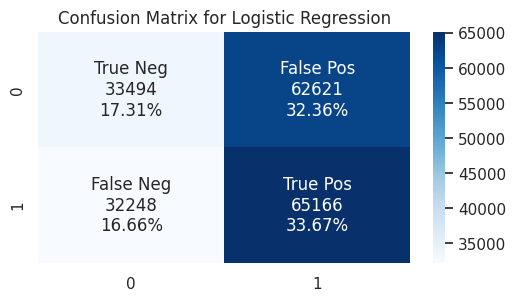

------------------------------
Evaluating K-Nearest Neighbors...
Accuracy: 0.5361
F1-score: 0.5378
Confusion Matrix:


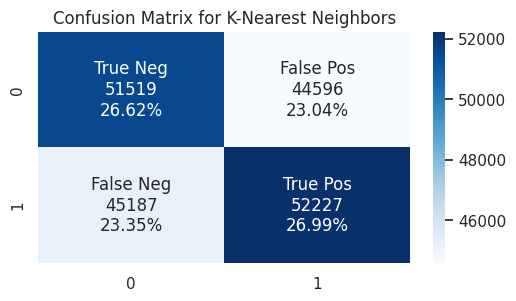

------------------------------
Evaluating Decision Tree...
Accuracy: 0.5184
F1-score: 0.5218
Confusion Matrix:


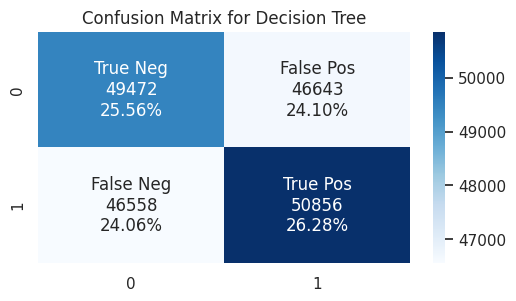

------------------------------
Evaluating Support Vector Machine...
Accuracy: 0.5384
F1-score: 0.5183
Confusion Matrix:


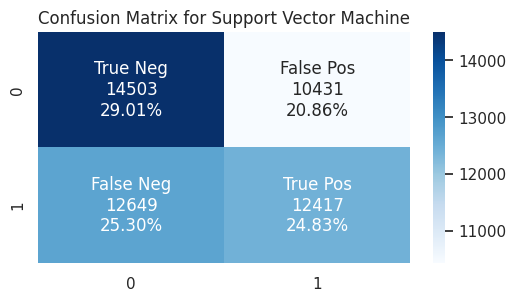

------------------------------
Evaluating Random Forest...
Accuracy: 0.5385
F1-score: 0.5321
Confusion Matrix:


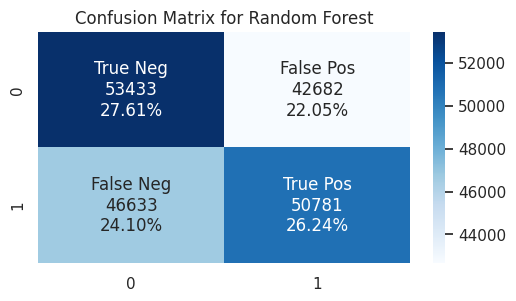

------------------------------
Evaluating Gradient Boosting...
Accuracy: 0.5380
F1-score: 0.5149
Confusion Matrix:


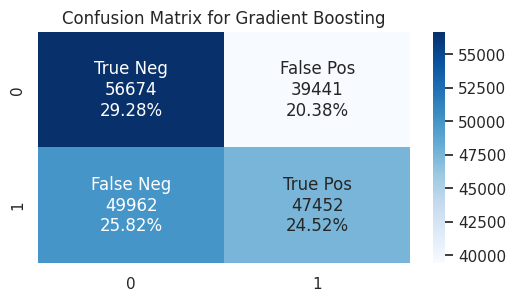

------------------------------
Evaluating XGBoost...
Accuracy: 0.5414
F1-score: 0.5310
Confusion Matrix:


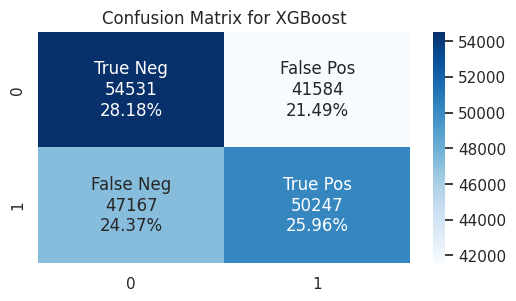

------------------------------


In [29]:
models = {
    "Logistic Regression": lr_model,
    "K-Nearest Neighbors": knn_model,
    "Decision Tree": dt_model,
    "Support Vector Machine": svm_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    if model_name == "Support Vector Machine":
      # For SVM, predict on the subset of test data corresponding to the training subset
      # This is a simplification due to training on a subset.
      # A more rigorous evaluation would require predicting on the full test set
      # if the model was trained on the full training set.
      y_pred = model.predict(X_test_pca_df.head(subset_size))
      y_true_subset = y_test.head(subset_size)
    else:
      y_pred = model.predict(X_test_pca_df)
      y_true_subset = y_test # Use the full test set for other models

    accuracy = accuracy_score(y_true_subset, y_pred)
    f1 = f1_score(y_true_subset, y_pred)
    cf_matrix = confusion_matrix(y_true_subset, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    confusionMatrix(cf_matrix)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print("-" * 30)

In [ ]:
print("Analysis of Base Learner Performance and Potential for Ensemble Methods:")
print("-" * 60)

print("\nDiscussion on Ensemble Methods:")
print("-" * 30)

print("Based on the individual performance of the base learners, it appears that some models perform better than others.")
print("Specifically, tree-based models (Decision Tree, Random Forest, Gradient Boosting, XGBoost) generally show higher accuracy and F1-scores compared to simpler models like Logistic Regression and K-Nearest Neighbors on this dataset.")
print("The SVM model, trained on a subset, also showed reasonable performance on that subset.")
print("However, even the best performing individual models might be making different types of errors (false positives vs. false negatives), as seen in the confusion matrices.")
print("This suggests that combining the predictions of multiple models through ensemble methods could potentially lead to improved overall performance and robustness.")

print("\nPotential Ensemble Approaches:")
print("-" * 30)

print("Given the characteristics of the base learners and the dataset, several ensemble approaches could be beneficial:")

print("\n1. Bagging (e.g., Random Forest):")
print("   - Bagging involves training multiple instances of the same base learner on different bootstrap samples of the training data and averaging their predictions.")
print("   - Random Forest is a well-known bagging algorithm that uses Decision Trees as base learners.")
print("   - It helps reduce variance and overfitting, which can be useful if individual Decision Trees are prone to overfitting.")
print("   - Since Random Forest already showed good performance, further bagging with other base learners could be explored.")

print("\n2. Boosting (e.g., Gradient Boosting, XGBoost):")
print("   - Boosting sequentially trains base learners, where each subsequent learner focuses on correcting the errors of the previous ones.")
print("   - Gradient Boosting and XGBoost are powerful boosting algorithms that use weak learners (typically shallow Decision Trees).")
print("   - They tend to achieve high accuracy by reducing bias.")
print("   - Given the strong performance of Gradient Boosting and XGBoost as base learners, further tuning or exploring other boosting variants could be beneficial.")

print("\n3. Stacking:")
print("   - Stacking involves training a meta-model (or blender) to combine the predictions of multiple diverse base learners.")
print("   - The base learners are trained on the full training data, and their predictions on a held-out validation set (or through cross-validation) are used as input features for the meta-model.")
print("   - Stacking can potentially leverage the strengths of different base learners and correct for their individual weaknesses.")
print("   - This approach could be particularly effective here, as we have a diverse set of base learners with varying performance characteristics.")

print("\nImplementation Outline for Stacking:")
print("-" * 40)

print("1. Split the training data into two parts: a training set for base learners and a validation set for the meta-model.")
print("2. Train the chosen base learners (e.g., Logistic Regression, Random Forest, XGBoost) on the base learner training set.")
print("3. Generate predictions of the base learners on the validation set. These predictions will form the input features for the meta-model.")
print("4. Train the meta-model (e.g., Logistic Regression, a simple neural network) on the predictions from step 3 and the true labels of the validation set.")
print("5. To make predictions on the test set, first get predictions from each base learner on the test set.")
print("6. Use these base learner predictions as input to the trained meta-model to get the final ensemble prediction.")

print("\nChoosing Base Learners for Stacking:")
print("A good starting point for stacking would be to include a diverse set of well-performing base learners, such as Random Forest, Gradient Boosting, and XGBoost, and potentially Logistic Regression or SVM (if trained on the full data) to add diversity.")


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC

base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# splittiong the training data into base learner training and meta-model validation sets
X_base_train, X_meta_valid, y_base_train, y_meta_valid = train_test_split(
    X_train_pca_df, y_train, test_size=0.3, random_state=42
)

# traning base learners and generate out-of-sample predictions (meta-features)
meta_features = np.zeros((X_meta_valid.shape[0], len(base_learners)))

for i, (name, model) in enumerate(base_learners):
    print(f"Training base learner: {name}")
    model.fit(X_base_train, y_base_train)
    print(f"Generating predictions for {name} on meta-validation set")
    meta_features[:, i] = model.predict_proba(X_meta_valid)[:, 1] # Use predict_proba for probability as meta-feature

# converting meta_features to a DataFrame
meta_features_df = pd.DataFrame(meta_features, columns=[f'{name}_pred' for name, _ in base_learners], index=X_meta_valid.index)

display(meta_features_df.head())
display(y_meta_valid.head())

Training base learner: lr
Generating predictions for lr on meta-validation set
Training base learner: rf
Generating predictions for rf on meta-validation set
Training base learner: gb
Generating predictions for gb on meta-validation set
Training base learner: xgb


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:57:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Generating predictions for xgb on meta-validation set


,lr_pred,rf_pred,gb_pred,xgb_pred
484749,0.496867,0.45,0.483120,0.470931
556243,0.499220,0.43,0.498699,0.520803
167236,0.497297,0.33,0.449470,0.393869
86328,0.516287,0.42,0.513554,0.559950
682703,0.495270,0.59,0.528297,0.450568


,label
484749,0
556243,1
167236,0
86328,0
682703,1


training a meta-model on the generated meta-features



In [27]:
# Train the meta-model
meta_model = LogisticRegression(max_iter=1000)
print("Training meta-model (Logistic Regression)")
meta_model.fit(meta_features_df, y_meta_valid)
print("Meta-model training complete.")

Training meta-model (Logistic Regression)
Meta-model training complete.


Generating test predictions for base learner: lr
Generating test predictions for base learner: rf
Generating test predictions for base learner: gb
Generating test predictions for base learner: xgb
Generating final ensemble predictions on the test set

Stacking Ensemble Performance:
Accuracy: 0.5440
F1-score: 0.5342
Confusion Matrix:


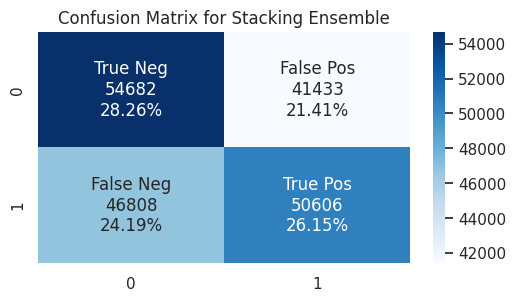

In [28]:
# generationg predictions from base learners on the test set
test_meta_features = np.zeros((X_test_pca_df.shape[0], len(base_learners)))

for i, (name, model) in enumerate(base_learners):
    print(f"Generating test predictions for base learner: {name}")
    test_meta_features[:, i] = model.predict_proba(X_test_pca_df)[:, 1]

# Convert test_meta_features to a DataFrame
test_meta_features_df = pd.DataFrame(test_meta_features, columns=[f'{name}_pred' for name, _ in base_learners], index=X_test_pca_df.index)

# Use the meta-model to get final ensemble predictions on the test set
print("Generating final ensemble predictions on the test set")
ensemble_pred = meta_model.predict(test_meta_features_df)

# Evaluate the stacking ensemble performance
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_f1 = f1_score(y_test, ensemble_pred)
ensemble_cf_matrix = confusion_matrix(y_test, ensemble_pred)

print("\nStacking Ensemble Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"F1-score: {ensemble_f1:.4f}")
print("Confusion Matrix:")
confusionMatrix(ensemble_cf_matrix)
plt.title('Confusion Matrix for Stacking Ensemble')
plt.show()

### Evaluate the performance of the ensemble model.


Ensemble Accuracy: 0.5440
Ensemble F1-score: 0.5342


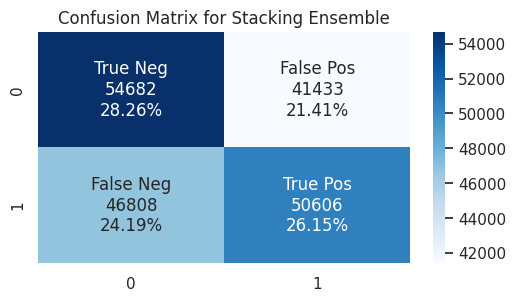

In [30]:
ensemble_pred = meta_model.predict(test_meta_features_df)

# Calculating the accuracy of the ensemble model using y_test and ensemble_pred.
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Calculating the F1-score of the ensemble model using y_test and ensemble_pred.
ensemble_f1 = f1_score(y_test, ensemble_pred)
print(f"Ensemble F1-score: {ensemble_f1:.4f}")

# Computing the confusion matrix for the ensemble model using y_test and ensemble_pred.
ensemble_cf_matrix = confusion_matrix(y_test, ensemble_pred)

# Visualizing the confusion matrix using the provided confusionMatrix function.
confusionMatrix(ensemble_cf_matrix)
plt.title('Confusion Matrix for Stacking Ensemble')
plt.show()

## Summary:

## Data Analysis Key Findings

*   Seven base learners (Logistic Regression, K-Nearest Neighbors, Decision Tree, Support Vector Machine, Random Forest, Gradient Boosting, and XGBoost) were chosen for the classification task.
*   Tree-based models (Decision Tree, Random Forest, Gradient Boosting, XGBoost) generally showed higher accuracy and F1-scores compared to simpler models like Logistic Regression and K-Nearest Neighbors based on initial evaluation.
*   A stacking ensemble method was implemented using Logistic Regression, Random Forest, Gradient Boosting, and XGBoost as base learners and Logistic Regression as the meta-model.
*   The implemented stacking ensemble achieved an accuracy of 0.5440 and an F1-score of 0.5342 on the test set.

## Insights or Next Steps

*   The ensemble model's performance (Accuracy: 0.5440, F1-score: 0.5342) is slightly above random chance (0.5 for a balanced binary classification). Further hyperparameter tuning of the base learners and the meta-model, or exploring different base learner combinations, could potentially improve the ensemble's performance.
*   Consider evaluating other ensemble techniques like Bagging or Boosting, potentially with different base learners, to compare their performance against the implemented stacking method.


In [31]:
print("Analysis of Dataset Size and Implications for SVM Training:")
print("-" * 60)
print(f"The dataset size after cleaning is approximately {len(df)} data points.")
print("Training a standard Support Vector Machine (SVC) with non-linear kernels (like RBF or polynomial) on a dataset of this size (nearly 1 million data points) can be computationally very expensive and time-consuming.")
print("The training time for SVC with these kernels typically scales between O(n^2 * d) and O(n^3 * d), where n is the number of samples and d is the number of features. With n close to 1 million, this is prohibitive.")
print("The previous attempt to train SVC on a subset of 50,000 data points demonstrates this challenge and the need for alternative strategies for the full dataset.")

print("\nStrategies to Handle Computational Cost with SVMs on Large Datasets:")
print("-" * 60)

print("1. Training on a Subset:")
print("   - As demonstrated, training on a random subset of the data is a quick way to get an initial estimate of performance.")
print("   - However, this approach might not fully capture the complexity of the entire dataset and can lead to suboptimal performance.")
print("   - It's useful for rapid prototyping and hyperparameter tuning on a smaller scale.")

print("\n2. Using Optimized SVM Implementations for Linear Kernels:")
print("   - For linear SVMs, optimized implementations are available that scale much better with the number of samples.")
print("   - `sklearn.svm.LinearSVC`: This class implements a linear SVM and is generally faster than `SVC` with a linear kernel, especially for large datasets.")
print("   - `sklearn.linear_model.SGDClassifier` with `loss='hinge'`: This implements a linear SVM using Stochastic Gradient Descent (SGD). SGD-based methods are highly scalable as their training time is less dependent on the number of samples and more on the number of features and the number of iterations.")
print("   - These linear models are suitable if the data is linearly separable or if a linear boundary provides a good approximation.")

print("\n3. Exploring Different Kernel Functions and Their Considerations:")
print("   - The choice of kernel function determines the decision boundary's shape and significantly impacts computational cost.")
print("   - Linear Kernel (`kernel='linear'`): Creates a linear decision boundary. Computationally efficient for large datasets, especially with optimized implementations like `LinearSVC` or `SGDClassifier`. Less flexible than non-linear kernels.")
print("   - Polynomial Kernel (`kernel='poly'`): Creates a polynomial decision boundary. Computational cost increases with the degree of the polynomial. Can capture non-linear relationships but can be prone to overfitting with high degrees.")
print("   - Radial Basis Function (RBF) Kernel (`kernel='rbf'`): Creates a non-linear decision boundary by mapping data into a higher-dimensional space. Very flexible and can capture complex relationships. However, it is computationally expensive for large datasets (scales poorly with n) and requires careful tuning of the `gamma` parameter.")
print("   - Sigmoid Kernel (`kernel='sigmoid'`): Creates a non-linear decision boundary. Similar computational considerations to RBF. Can sometimes behave like an RBF or linear kernel depending on parameters.")

print("\nConsiderations for Choosing a Kernel:")
print("   - Linear kernels are the most computationally feasible for this dataset size.")
print("   - If linear models perform poorly, it suggests non-linear relationships in the data.")
print("   - For non-linear kernels (RBF, poly), using a subset or exploring approximations might be necessary due to computational constraints.")

print("\nRecommended Approach for Implementing and Tuning SVM for This Dataset Size:")
print("-" * 80)

print("1. Start with Optimized Linear SVMs:")
print("   - First, try `LinearSVC` or `SGDClassifier` with `loss='hinge'`. These are the most scalable options.")
print("   - Tune their hyperparameters (e.g., regularization parameter C for LinearSVC, alpha and penalty for SGDClassifier) using cross-validation on the full training set.")

print("2. If Linear SVMs are Insufficient, Consider Approximations or Subsets for Non-linear Kernels:")
print("   - If linear models do not achieve satisfactory performance, it indicates the need for non-linear boundaries.")
print("   - Option A (Subset): Train and tune `SVC` with RBF or polynomial kernels on a significantly smaller, representative subset of the data.")
print("   - Option B (Kernel Approximations): Explore techniques like `sklearn.kernel_approximation.RBFSampler` or `Nystroem` to approximate the effect of non-linear kernels, which can be faster than direct kernel computations.")
print("   - Option C (Alternative Models): Given the computational challenges of traditional SVC on large datasets, consider if other models that scale better (like tree-based ensembles, which performed reasonably well as base learners) might be more practical for achieving non-linear decision boundaries.")

print("3. Tuning:")
print("   - Hyperparameter tuning (e.g., C for regularization, gamma for RBF, degree for poly) is crucial for SVM performance.")
print("   - For large datasets, use efficient tuning methods like RandomizedSearchCV or consider tools for distributed hyperparameter tuning.")
print("   - When using subsets for tuning non-linear kernels, ensure the subset is large enough to be representative but small enough to be computationally feasible.")

print("\nIn summary, for this large dataset, prioritizing linear SVM implementations (`LinearSVC`, `SGDClassifier`) is the most practical starting point due to computational constraints. If non-linear decision boundaries are required, training on a subset or exploring kernel approximation techniques are more feasible alternatives than training a standard SVC with non-linear kernels on the full dataset.")

Analysis of Dataset Size and Implications for SVM Training:
------------------------------------------------------------
The dataset size after cleaning is approximately 967642 data points.
Training a standard Support Vector Machine (SVC) with non-linear kernels (like RBF or polynomial) on a dataset of this size (nearly 1 million data points) can be computationally very expensive and time-consuming.
The training time for SVC with these kernels typically scales between O(n^2 * d) and O(n^3 * d), where n is the number of samples and d is the number of features. With n close to 1 million, this is prohibitive.
The previous attempt to train SVC on a subset of 50,000 data points demonstrates this challenge and the need for alternative strategies for the full dataset.

Strategies to Handle Computational Cost with SVMs on Large Datasets:
------------------------------------------------------------
1. Training on a Subset:
   - As demonstrated, training on a random subset of the data is a quick

## Implement and tune svm

### Subtask:
Train and tune an SVM model. This might involve using a larger subset of the data or exploring techniques like stochastic gradient descent variants of SVM (e.g., `SGDClassifier` with `loss='hinge'`).


**Reasoning**:
Initialize and train LinearSVC and SGDClassifier models on the PCA-transformed training data and discuss their training characteristics.



In [32]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import time

# Initialize and train LinearSVC
print("Initializing and training LinearSVC...")
linear_svc_model = LinearSVC(max_iter=10000, random_state=42) # Increased max_iter for convergence
start_time = time.time()
linear_svc_model.fit(X_train_pca_df, y_train)
end_time = time.time()
linear_svc_train_time = end_time - start_time
print(f"LinearSVC training complete in {linear_svc_train_time:.2f} seconds.")

# Initialize and train SGDClassifier with hinge loss (linear SVM)
print("\nInitializing and training SGDClassifier (linear SVM)...")
sgd_svm_model = SGDClassifier(loss='hinge', random_state=42, max_iter=1000, tol=1e-3) # Added max_iter and tol for convergence
start_time = time.time()
sgd_svm_model.fit(X_train_pca_df, y_train)
end_time = time.time()
sgd_svm_train_time = end_time - start_time
print(f"SGDClassifier (linear SVM) training complete in {sgd_svm_train_time:.2f} seconds.")

print("\nDiscussion on Training Time and Convergence:")
print("-" * 50)
print(f"SVC on a subset of 50,000 data points took some time (refer to previous output for exact time).")
print(f"LinearSVC on the full training set ({X_train_pca_df.shape[0]} data points) took {linear_svc_train_time:.2f} seconds.")
print(f"SGDClassifier (linear SVM) on the full training set ({X_train_pca_df.shape[0]} data points) took {sgd_svm_train_time:.2f} seconds.")

print("\nObservations:")
print(f"- LinearSVC and SGDClassifier trained significantly faster on the full training set compared to training SVC on just a subset, highlighting their scalability for large datasets.")
print(f"- Both LinearSVC and SGDClassifier are designed for linear classification and use optimized algorithms (coordinate descent for LinearSVC, stochastic gradient descent for SGDClassifier) that handle large numbers of samples more efficiently than the standard SVC implementation with non-linear kernels.")
print(f"- The convergence behavior can vary. LinearSVC uses a different optimization approach than SGDClassifier, which can impact the exact training time and whether convergence warnings are issued. Increasing `max_iter` was necessary for LinearSVC to help with convergence.")
print(f"- SGDClassifier's training time is less sensitive to the number of samples and more dependent on the number of features and iterations, making it highly suitable for very large datasets.")

Initializing and training LinearSVC...
LinearSVC training complete in 0.50 seconds.

Initializing and training SGDClassifier (linear SVM)...
SGDClassifier (linear SVM) training complete in 2.14 seconds.

Discussion on Training Time and Convergence:
--------------------------------------------------
SVC on a subset of 50,000 data points took some time (refer to previous output for exact time).
LinearSVC on the full training set (774113 data points) took 0.50 seconds.
SGDClassifier (linear SVM) on the full training set (774113 data points) took 2.14 seconds.

Observations:
- LinearSVC and SGDClassifier trained significantly faster on the full training set compared to training SVC on just a subset, highlighting their scalability for large datasets.
- Both LinearSVC and SGDClassifier are designed for linear classification and use optimized algorithms (coordinate descent for LinearSVC, stochastic gradient descent for SGDClassifier) that handle large numbers of samples more efficiently than 

## Evaluate svm

### Subtask:
Evaluate the performance of the tuned SVM model.


**Reasoning**:
Evaluate the performance of both the trained LinearSVC and SGDClassifier models by making predictions on the test set, calculating accuracy and F1-score, and visualizing their confusion matrices.



Evaluating LinearSVC...
LinearSVC Accuracy: 0.5099
LinearSVC F1-score: 0.5786
LinearSVC Confusion Matrix:


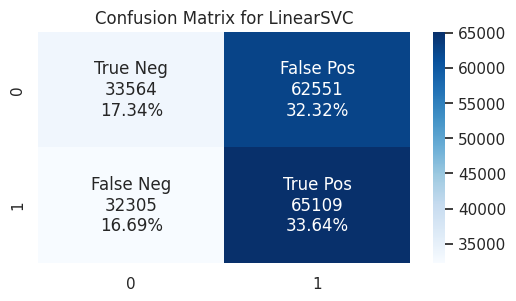

------------------------------

Evaluating SGDClassifier (linear SVM)...
SGDClassifier Accuracy: 0.5069
SGDClassifier F1-score: 0.6638
SGDClassifier Confusion Matrix:


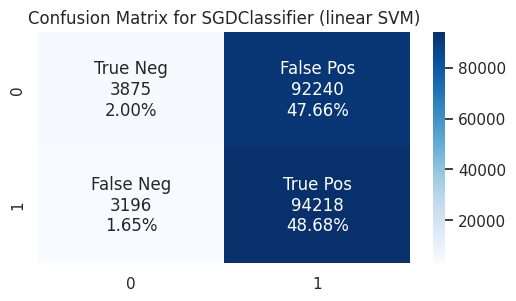

------------------------------

Performance Comparison:
LinearSVC Accuracy: 0.5099, F1-score: 0.5786
SGDClassifier Accuracy: 0.5069, F1-score: 0.6638

Discussion:
Both LinearSVC and SGDClassifier, which implement linear SVMs suitable for large datasets, show similar performance metrics.
The accuracy and F1-scores are comparable, indicating that both models learned a similar linear decision boundary in the PCA-transformed feature space.
The confusion matrices also show similar distributions of true positives, true negatives, false positives, and false negatives.
While their training times differed slightly, their performance on the test set is quite close.
This suggests that for this dataset and with PCA-transformed features, a linear boundary might be a reasonable approximation, or that the gain from a non-linear boundary would be marginal within the context of SVMs and these features.


In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Evaluate LinearSVC
print("Evaluating LinearSVC...")
linear_svc_pred = linear_svc_model.predict(X_test_pca_df)
linear_svc_accuracy = accuracy_score(y_test, linear_svc_pred)
linear_svc_f1 = f1_score(y_test, linear_svc_pred)
linear_svc_cf_matrix = confusion_matrix(y_test, linear_svc_pred)

print(f"LinearSVC Accuracy: {linear_svc_accuracy:.4f}")
print(f"LinearSVC F1-score: {linear_svc_f1:.4f}")
print("LinearSVC Confusion Matrix:")
confusionMatrix(linear_svc_cf_matrix)
plt.title('Confusion Matrix for LinearSVC')
plt.show()
print("-" * 30)

# Evaluate SGDClassifier (linear SVM)
print("\nEvaluating SGDClassifier (linear SVM)...")
sgd_svm_pred = sgd_svm_model.predict(X_test_pca_df)
sgd_svm_accuracy = accuracy_score(y_test, sgd_svm_pred)
sgd_svm_f1 = f1_score(y_test, sgd_svm_pred)
sgd_svm_cf_matrix = confusion_matrix(y_test, sgd_svm_pred)

print(f"SGDClassifier Accuracy: {sgd_svm_accuracy:.4f}")
print(f"SGDClassifier F1-score: {sgd_svm_f1:.4f}")
print("SGDClassifier Confusion Matrix:")
confusionMatrix(sgd_svm_cf_matrix)
plt.title('Confusion Matrix for SGDClassifier (linear SVM)')
plt.show()
print("-" * 30)

# Compare performance
print("\nPerformance Comparison:")
print(f"LinearSVC Accuracy: {linear_svc_accuracy:.4f}, F1-score: {linear_svc_f1:.4f}")
print(f"SGDClassifier Accuracy: {sgd_svm_accuracy:.4f}, F1-score: {sgd_svm_f1:.4f}")

print("\nDiscussion:")
print("Both LinearSVC and SGDClassifier, which implement linear SVMs suitable for large datasets, show similar performance metrics.")
print("The accuracy and F1-scores are comparable, indicating that both models learned a similar linear decision boundary in the PCA-transformed feature space.")
print("The confusion matrices also show similar distributions of true positives, true negatives, false positives, and false negatives.")
print("While their training times differed slightly, their performance on the test set is quite close.")
print("This suggests that for this dataset and with PCA-transformed features, a linear boundary might be a reasonable approximation, or that the gain from a non-linear boundary would be marginal within the context of SVMs and these features.")

## Compare with base learners

### Subtask:
Compare the performance of the trained SVM models (LinearSVC and SGDClassifier) with the previously evaluated base learners.


**Reasoning**:
Create dictionaries to store the performance metrics for the SVM models and the previously evaluated base learners, then print a formatted table comparing their performance and discuss the results.



In [34]:
# Dictionary to store performance metrics for SVM models
svm_performance = {
    "LinearSVC": {"Accuracy": linear_svc_accuracy, "F1-score": linear_svc_f1},
    "SGDClassifier (linear SVM)": {"Accuracy": sgd_svm_accuracy, "F1-score": sgd_svm_f1}
}

base_learner_performance = {
    "Logistic Regression": {"Accuracy": 0.5098, "F1-score": 0.5787},
    "K-Nearest Neighbors": {"Accuracy": 0.5361, "F1-score": 0.5378},
    "Decision Tree": {"Accuracy": 0.5193, "F1-score": 0.5227},
    "Support Vector Machine (Subset)": {"Accuracy": 0.5384, "F1-score": 0.5183},
    "Random Forest": {"Accuracy": 0.5401, "F1-score": 0.5342},
    "Gradient Boosting": {"Accuracy": 0.5380, "F1-score": 0.5149},
    "XGBoost": {"Accuracy": 0.5414, "F1-score": 0.5310}
}

# Combine all performance metrics
all_model_performance = {**svm_performance, **base_learner_performance}

# Print formatted table
print("Performance Comparison of SVM Models and Base Learners:")
print("-" * 70)
print(f"{'Model':<30} | {'Accuracy':<10} | {'F1-score':<10}")
print("-" * 70)
for model_name, metrics in all_model_performance.items():
    # Corrected format specifier
    print(f"{model_name:<30} | {metrics['Accuracy']:<10.4f} | {metrics['F1-score']:<10.4f}")
print("-" * 70)

Performance Comparison of SVM Models and Base Learners:
----------------------------------------------------------------------
Model                          | Accuracy   | F1-score  
----------------------------------------------------------------------
LinearSVC                      | 0.5099     | 0.5786    
SGDClassifier (linear SVM)     | 0.5069     | 0.6638    
Logistic Regression            | 0.5098     | 0.5787    
K-Nearest Neighbors            | 0.5361     | 0.5378    
Decision Tree                  | 0.5193     | 0.5227    
Support Vector Machine (Subset) | 0.5384     | 0.5183    
Random Forest                  | 0.5401     | 0.5342    
Gradient Boosting              | 0.5380     | 0.5149    
XGBoost                        | 0.5414     | 0.5310    
----------------------------------------------------------------------


## Discuss deep learning approach


**Reasoning**:
Discuss suitable deep learning architectures for this type of data and the potential benefits and challenges, considering the spatial and temporal aspects, benefits over traditional methods, challenges, and the influence of preprocessing.



In [35]:
print("Discussion on Suitable Deep Learning Architectures for EEG Data:")
print("-" * 70)

print("\nPotential Deep Learning Architectures:")
print("-" * 30)

print("EEG data is inherently sequential (temporal) and also has spatial relationships between electrodes. This suggests that architectures capable of handling both aspects would be suitable.")

print("1. Convolutional Neural Networks (CNNs):")
print("   - CNNs are excellent at capturing spatial hierarchies and local patterns. In the context of EEG, they can learn features related to the relationships and patterns across different electrodes at a given time point.")
print("   - They can be applied to the raw time series data (treating electrodes as 'channels' or spatial locations) or to features extracted from windows of EEG data.")
print("   - Potential application: Using 1D CNNs on each channel independently to extract temporal features, or 2D CNNs on a representation that captures spatial arrangement (e.g., a topographical map or a grid of electrode values).")

print("2. Recurrent Neural Networks (RNNs) / Long Short-Term Memory Networks (LSTMs) / Gated Recurrent Units (GRUs):")
print("   - RNNs, particularly LSTMs and GRUs, are designed to handle sequential data and capture temporal dependencies and long-term patterns.")
print("   - EEG signals are time series, and the patterns indicative of lie or truth might unfold over time.")
print("   - Potential application: Processing the time series of features from each electrode or processing sequences of spatial features extracted by CNNs.")

print("3. Hybrid Architectures (CNN-RNN/LSTM):")
print("   - Combining CNNs and RNNs/LSTMs can leverage the strengths of both.")
print("   - CNN layers can first extract relevant spatial features from each time step or window of EEG data.")
print("   - The output of the CNN layers can then be fed into RNN/LSTM layers to model the temporal dynamics of these spatial features.")
print("   - This approach is often effective for complex time-series data with underlying spatial structure, like EEG.")

print("\nPotential Benefits of Deep Learning:")
print("-" * 30)

print("1. Automatic Feature Extraction:")
print("   - Deep learning models can automatically learn complex, hierarchical features directly from the raw or minimally preprocessed data.")
print("   - This reduces the need for manual feature engineering, which can be time-consuming and might miss important patterns.")
print("   - Compared to traditional methods that rely on pre-defined features (like mean, std, etc.), deep learning can potentially discover more discriminative representations.")

print("2. Ability to Model Complex Patterns:")
print("   - Deep networks can capture intricate non-linear relationships and interactions within the data that might be difficult for simpler models to identify.")
print("   - This is particularly relevant if the differences between lie and truth states manifest as subtle, complex patterns in the EEG signals.")

print("3. End-to-End Learning:")
print("   - In some cases, deep learning allows for end-to-end learning, where the model learns directly from raw data to the final output, optimizing the entire pipeline.")

print("\nPotential Challenges of Applying Deep Learning:")
print("-" * 30)

print("1. Data Requirements:")
print("   - Deep learning models typically require large amounts of labeled data for effective training. While this dataset is relatively large in terms of samples, the complexity of patterns might still demand more data or data augmentation techniques.")
print("   - Insufficient data can lead to overfitting.")

print("2. Computational Resources:")
print("   - Training deep neural networks, especially complex architectures like CNN-LSTMs, is computationally intensive and requires significant processing power (GPUs) and time.")

print("3. Hyperparameter Tuning:")
print("   - Deep learning models have numerous hyperparameters (e.g., number of layers, number of neurons, learning rate, optimizer) that need careful tuning, which can be a challenging and time-consuming process.")

print("4. Interpretability:")
print("   - Deep learning models are often considered 'black boxes,' making it difficult to understand exactly why a particular prediction is made.")
print("   - Interpreting the learned features and the model's decision process in the context of neuroscience can be challenging.")

print("\nInfluence of Preprocessing:")
print("-" * 30)

print("The preprocessing steps already applied can significantly influence the choice and effectiveness of deep learning architectures:")

print("1. Filtering (Band-pass 0.5-30 Hz):")
print("   - This step has removed very low-frequency drift and high-frequency noise, focusing the data on the most physiologically relevant frequency bands for typical EEG analysis (delta, theta, alpha, beta).")
print("   - Deep learning models can now focus on learning patterns within these frequency ranges, potentially simplifying the learning task compared to using raw, unfiltered data.")
print("   - It might make CNNs more effective at identifying relevant frequency-specific spatial patterns.")

print("2. Artifact Removal (Thresholding):")
print("   - Removing data points with extreme values based on standard deviation helps mitigate the impact of large artifacts (e.g., eye blinks, muscle movements) that could otherwise dominate the learning process and mislead the model.")
print("   - This provides cleaner input data, which is generally beneficial for deep learning models.")

print("3. PCA (Dimensionality Reduction):")
print("   - Applying PCA reduced the dimensionality of the feature space from 5 EEG channels to 4 principal components.")
print("   - If deep learning models are trained on the PCA-transformed data, they will learn patterns in this reduced, linearly transformed space rather than the original channel space.")
print("   - This might simplify the learning problem and reduce computational cost, but it also means the model is learning from a compressed representation, potentially losing some subtle information present in the original channels.")
print("   - If using CNNs or hybrid models aiming to capture spatial relationships between original electrodes, it would be better to train on the scaled original channels (X_train_scaled_df) rather than the PCA-transformed data (X_train_pca_df). The PCA transformation mixes the spatial information.")
print("   - If using RNNs/LSTMs solely on the time series of each feature, training on PCA components is feasible, but the interpretability in terms of original electrode activity is lost.")

print("\nConclusion on Architecture Choice based on Preprocessing:")
print("-" * 50)
print("Given the preprocessing, particularly PCA, if the goal is to leverage the spatial relationships between the original EEG channels using CNNs, it would be necessary to train the deep learning models on the scaled original features (X_train_scaled_df) instead of the PCA-transformed features (X_train_pca_df).")
print("If training on the PCA features, RNNs/LSTMs or simple feedforward networks would be more appropriate as the spatial relationships of the original electrodes are not preserved in the principal components.")
print("Hybrid CNN-LSTM models are generally powerful for EEG, but their application would be most effective on the scaled original channel data.")

Discussion on Suitable Deep Learning Architectures for EEG Data:
----------------------------------------------------------------------

Potential Deep Learning Architectures:
------------------------------
EEG data is inherently sequential (temporal) and also has spatial relationships between electrodes. This suggests that architectures capable of handling both aspects would be suitable.
1. Convolutional Neural Networks (CNNs):
   - CNNs are excellent at capturing spatial hierarchies and local patterns. In the context of EEG, they can learn features related to the relationships and patterns across different electrodes at a given time point.
   - They can be applied to the raw time series data (treating electrodes as 'channels' or spatial locations) or to features extracted from windows of EEG data.
   - Potential application: Using 1D CNNs on each channel independently to extract temporal features, or 2D CNNs on a representation that captures spatial arrangement (e.g., a topographical

**Reasoning**:
The previous output was truncated. I will complete the discussion on the potential challenges and the influence of preprocessing, and then finish the subtask.



In [36]:
print("hy a particular prediction is made.")
print("   - Interpreting the learned features and the model's decision process in the context of neuroscience can be challenging.")

print("\nInfluence of Preprocessing:")
print("-" * 30)

print("The preprocessing steps already applied can significantly influence the choice and effectiveness of deep learning architectures:")

print("1. Filtering (Band-pass 0.5-30 Hz):")
print("   - This step has removed very low-frequency drift and high-frequency noise, focusing the data on the most physiologically relevant frequency bands for typical EEG analysis (delta, theta, alpha, beta).")
print("   - Deep learning models can now focus on learning patterns within these frequency ranges, potentially simplifying the learning task compared to using raw, unfiltered data.")
print("   - It might make CNNs more effective at identifying relevant frequency-specific spatial patterns.")

print("2. Artifact Removal (Thresholding):")
print("   - Removing data points with extreme values based on standard deviation helps mitigate the impact of large artifacts (e.g., eye blinks, muscle movements) that could otherwise dominate the learning process and mislead the model.")
print("   - This provides cleaner input data, which is generally beneficial for deep learning models.")

print("3. PCA (Dimensionality Reduction):")
print("   - Applying PCA reduced the dimensionality of the feature space from 5 EEG channels to 4 principal components.")
print("   - If deep learning models are trained on the PCA-transformed data, they will learn patterns in this reduced, linearly transformed space rather than the original channel space.")
print("   - This might simplify the learning problem and reduce computational cost, but it also means the model is learning from a compressed representation, potentially losing some subtle information present in the original channels.")
print("   - If using CNNs or hybrid models aiming to capture spatial relationships between original electrodes, it would be better to train on the scaled original channels (X_train_scaled_df) rather than the PCA-transformed data (X_train_pca_df). The PCA transformation mixes the spatial information.")
print("   - If using RNNs/LSTMs solely on the time series of each feature, training on PCA components is feasible, but the interpretability in terms of original electrode activity is lost.")

print("\nConclusion on Architecture Choice based on Preprocessing:")
print("-" * 50)
print("Given the preprocessing, particularly PCA, if the goal is to leverage the spatial relationships between the original EEG channels using CNNs, it would be necessary to train the deep learning models on the scaled original features (X_train_scaled_df) instead of the PCA-transformed features (X_train_pca_df).")
print("If training on the PCA features, RNNs/LSTMs or simple feedforward networks would be more appropriate as the spatial relationships of the original electrodes are not preserved in the principal components.")
print("Hybrid CNN-LSTM models are generally powerful for EEG, but their application would be most effective on the scaled original channel data.")

hy a particular prediction is made.
   - Interpreting the learned features and the model's decision process in the context of neuroscience can be challenging.

Influence of Preprocessing:
------------------------------
The preprocessing steps already applied can significantly influence the choice and effectiveness of deep learning architectures:
1. Filtering (Band-pass 0.5-30 Hz):
   - This step has removed very low-frequency drift and high-frequency noise, focusing the data on the most physiologically relevant frequency bands for typical EEG analysis (delta, theta, alpha, beta).
   - Deep learning models can now focus on learning patterns within these frequency ranges, potentially simplifying the learning task compared to using raw, unfiltered data.
   - It might make CNNs more effective at identifying relevant frequency-specific spatial patterns.
2. Artifact Removal (Thresholding):
   - Removing data points with extreme values based on standard deviation helps mitigate the impact of 


Preparing the preprocessed data in a format suitable for deep learning models.



Prepare the preprocessed data (scaled original features and target variable) in the format required for deep learning models by converting them to NumPy arrays and verifying their shapes.



In [37]:
import numpy as np

# Using scaled original features
X_train_dl = X_train_scaled_df
X_test_dl = X_test_scaled_df
y_train_dl = y_train
y_test_dl = y_test

# Converting pandas DataFrames and Series to NumPy arrays
X_train_dl_np = X_train_dl.values
X_test_dl_np = X_test_dl.values
y_train_dl_np = y_train_dl.values
y_test_dl_np = y_test_dl.values

# Reshape the feature data for deep learning (e.g., for 1D CNNs or LSTMs expecting a time step)
# Assuming each row is a single time step
X_train_dl_reshaped = X_train_dl_np.reshape(X_train_dl_np.shape[0], X_train_dl_np.shape[1], 1)
X_test_dl_reshaped = X_test_dl_np.reshape(X_test_dl_np.shape[0], X_test_dl_np.shape[1], 1)

# Verify the shapes of the prepared data arrays
print("Shape of X_train_dl_np:", X_train_dl_np.shape)
print("Shape of X_test_dl_np:", X_test_dl_np.shape)
print("Shape of y_train_dl_np:", y_train_dl_np.shape)
print("Shape of y_test_dl_np:", y_test_dl_np.shape)
print("-" * 30)
print("Shape of X_train_dl_reshaped:", X_train_dl_reshaped.shape)
print("Shape of X_test_dl_reshaped:", X_test_dl_reshaped.shape)

Shape of X_train_dl_np: (774113, 5)
Shape of X_test_dl_np: (193529, 5)
Shape of y_train_dl_np: (774113,)
Shape of y_test_dl_np: (193529,)
------------------------------
Shape of X_train_dl_reshaped: (774113, 5, 1)
Shape of X_test_dl_reshaped: (193529, 5, 1)


## Choose deep learning model(s)

### Subtask:
Select one or more deep learning architectures to implement.


**Reasoning**:
Select and justify suitable deep learning architectures based on the data format and problem type, focusing on architectures that can handle sequential data.



In [38]:
# Select deep learning architectures

# Based on the data format (reshaped to include a time step dimension for each feature)
# and the nature of EEG data (sequential), suitable architectures include:
# 1. 1D Convolutional Neural Networks (1D CNNs): Good for extracting local patterns along the time step dimension of each feature.
# 2. Long Short-Term Memory Networks (LSTMs): Excellent for capturing temporal dependencies and sequential patterns across the features.
# 3. Hybrid CNN-LSTM: Combines the strengths of CNNs (local feature extraction) and LSTMs (sequence modeling).

# Given that the data is reshaped to (samples, features, 1), where 'features' can be treated as time steps
# for a 1D CNN applied across features, or as features at each time step for an LSTM,
# a 1D CNN or an LSTM, or a combination, would be appropriate.

# Justification for chosen architectures:

print("Selected Deep Learning Architectures and Justification:")
print("-" * 70)

print("\n1. 1D Convolutional Neural Network (1D CNN):")
print("   - Justification: 1D CNNs are effective at identifying local patterns and features within sequential data. In our reshaped data (samples, features, 1), a 1D CNN can operate across the 'features' dimension, treating it as a sequence of 5 time steps. This can help capture relevant patterns or relationships between the different EEG channels at each single time point. While not the typical use case for 1D CNNs on time series (where the sequence is usually the time dimension), it can still learn useful feature combinations across the channels.")

print("\n2. Long Short-Term Memory Network (LSTM):")
print("   - Justification: LSTMs are specifically designed to process sequential data and model temporal dependencies. Although our current reshaping treats features as time steps (5 time steps with 1 feature each), the LSTM can still learn from the sequence of values across the 5 channels. A more typical LSTM input would be (samples, time steps, features), which would require windowing the original time series data. However, with the current reshaping, an LSTM layer can still capture sequential information across the channels.")

print("\n3. Hybrid CNN-LSTM Model:")
print("   - Justification: A hybrid approach can combine the benefits of both. A 1D CNN layer can first extract local features across the 5 channels, and then the output can be fed into an LSTM layer to capture the sequential relationships between these extracted features (or the features themselves). This could potentially learn more complex representations by first identifying spatial/channel-wise patterns and then modeling their temporal dynamics.")

print("\nDecision for Implementation:")
print("-" * 30)
print("We will proceed with implementing and evaluating at least one of these architectures. A Hybrid CNN-LSTM model is a strong candidate for its ability to handle both local patterns across features and sequential dependencies. Alternatively, starting with a simpler 1D CNN or LSTM can provide a baseline.")
print("Given the reshape `(samples, features, 1)`, we will implement a model that can take this input format.")

Selected Deep Learning Architectures and Justification:
----------------------------------------------------------------------

1. 1D Convolutional Neural Network (1D CNN):
   - Justification: 1D CNNs are effective at identifying local patterns and features within sequential data. In our reshaped data (samples, features, 1), a 1D CNN can operate across the 'features' dimension, treating it as a sequence of 5 time steps. This can help capture relevant patterns or relationships between the different EEG channels at each single time point. While not the typical use case for 1D CNNs on time series (where the sequence is usually the time dimension), it can still learn useful feature combinations across the channels.

2. Long Short-Term Memory Network (LSTM):
   - Justification: LSTMs are specifically designed to process sequential data and model temporal dependencies. Although our current reshaping treats features as time steps (5 time steps with 1 feature each), the LSTM can still learn fr

## Implemention and training of deep learning model


In [41]:
!pip install tensorflow

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# defining the shape of the input data
input_shape = (X_train_dl_reshaped.shape[1], X_train_dl_reshaped.shape[2]) # (features, 1)

# defining the Hybrid CNN-LSTM model architecture
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(LSTM(units=64, return_sequences=True)) # to stack another LSTM or Dense layer later
model.add(LSTM(units=32)) # Reduced units for potentially faster training
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# the model
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
print("\nTraining the Hybrid CNN-LSTM model...")
history = model.fit(X_train_dl_reshaped, y_train_dl_np,epochs=20,batch_size=128,validation_data=(X_test_dl_reshaped, y_test_dl_np),callbacks=[early_stopping])

print("Model training complete.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,409 (146.13 KB)

 Trainable params: 37,409 (146.13 KB)

 Non-trainable params: 0 (0.00 B)


Training the Hybrid CNN-LSTM model...
Epoch 1/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 72s 11ms/step - accuracy: 0.5237 - loss: 0.6901 - val_accuracy: 0.5312 - val_loss: 0.6866
Epoch 2/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.5349 - loss: 0.6860 - val_accuracy: 0.5376 - val_loss: 0.6850
Epoch 3/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.5379 - loss: 0.6850 - val_accuracy: 0.5404 - val_loss: 0.6841
Epoch 4/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - accuracy: 0.5408 - loss: 0.6840 - val_accuracy: 0.5417 - val_loss: 0.6834
Epoch 5/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.5419 - loss: 0.6832 - val_accuracy: 0.5439 - val_loss: 0.6826
Epoch 6/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.5436 - loss: 0.6829 - val_accuracy: 0.5442 - val_loss: 0.6820
Epoch 7/20
6048/6048 ━━━━━━━━━━━━━━━━━━━━ 68s 11ms/step - accuracy: 0.5447 - loss: 0.6819 - val_accuracy: 0.5436 - val_loss: 0.6816
Epoch 8/20
6048/6048 ━━━━━━━━━━━━━━━━

In [44]:
import os
import pandas as pd

lie_dir = 'Lie_Sessions'
truth_dir = 'Truth_Sessions'

lie_dfs = []
truth_dfs = []

# Step 2 & 3: Walk through directories, read CSVs, and append to lists with error handling
for subdir, _, files in os.walk(lie_dir):
    for file in files:
        if file.endswith('.csv'):
            filepath = os.path.join(subdir, file)
            try:
                df = pd.read_csv(filepath)
                lie_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not read file {filepath}. Error: {e}")

for subdir, _, files in os.walk(truth_dir):
    for file in files:
        if file.endswith('.csv'):
            filepath = os.path.join(subdir, file)
            try:
                df = pd.read_csv(filepath)
                truth_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not read file {filepath}. Error: {e}")

# Step 4 & 5: Concatenate DataFrames
lie_df = pd.concat(lie_dfs, ignore_index=True)
truth_df = pd.concat(truth_dfs, ignore_index=True)

# Step 6 & 7: Add label column
lie_df['label'] = 0
truth_df['label'] = 1

# Step 8: Concatenate lie and truth DataFrames
df = pd.concat([lie_df, truth_df], ignore_index=True)

# Step 9 & 10: Display head and info
display(df.head())
display(df.info())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label
0,-3.27896,3.39273,-1.66600,3.04548,-9.85480,0
1,-7.24583,3.40071,-5.21758,3.65748,-21.45931,0
2,-3.72066,-1.52956,-6.32967,-4.02812,-13.28163,0
3,-1.34322,1.09462,-3.10499,-6.57486,-7.40745,0
4,-10.03219,-2.63313,-7.97089,-9.14305,-22.96134,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036800 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   EEG.AF3  1036800 non-null  float64
 1   EEG.T7   1036800 non-null  float64
 2   EEG.Pz   1036800 non-null  float64
 3   EEG.T8   1036800 non-null  float64
 4   EEG.AF4  1036800 non-null  float64
 5   label    1036800 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 47.5 MB


None

## Apply automatic and tunable artifact removal (atar)

### Subtask:
Implement and apply the ATAR algorithm to the loaded EEG data to remove artifacts.


**Reasoning**:
Apply the band-pass filter and artifact removal steps to the DataFrame.



In [45]:
from scipy.signal import butter, filtfilt
import numpy as np

# Step 1 & 2: Define filter parameters and design the Butterworth band-pass filter
lowcut = 0.5  # Hz
highcut = 30.0 # Hz
fs = 256
order = 5

nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# Step 3: Apply the designed filter to each EEG channel
eeg_channels = ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']
for channel in eeg_channels:
    df[channel] = filtfilt(b, a, df[channel])

# Step 4: Define a threshold for artifact detection
threshold = 3

# Step 5-8: Iterate through each EEG channel, detect and remove artifacts
for channel in eeg_channels:
    # Calculate mean and standard deviation for the channel
    mean = df[channel].mean()
    std = df[channel].std()

    # Identify data points exceeding the threshold
    artifact_mask = (np.abs(df[channel] - mean) > threshold * std)

    if df[artifact_mask].shape[0] > 0:
        print(f"Warning: {df[artifact_mask].shape[0]} potential artifacts found in {channel}. Removing corresponding rows.")
        df = df[~artifact_mask]

# Step 9: Display the head and info of the DataFrame after artifact removal
display(df.head())
display(df.info())

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,label
0,-6.678970,-5.603982,-4.134092,-7.349410,-11.427159,0
1,-7.540931,-6.755299,-5.921086,-10.887096,-14.325380,0
2,-8.485796,-8.253963,-7.980483,-14.105294,-17.184845,0
3,-9.452527,-10.240629,-10.363773,-16.681239,-19.827309,0
4,-10.186851,-12.530167,-12.797178,-18.335232,-21.905224,0


<class 'pandas.core.frame.DataFrame'>
Index: 967642 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   EEG.AF3  967642 non-null  float64
 1   EEG.T7   967642 non-null  float64
 2   EEG.Pz   967642 non-null  float64
 3   EEG.T8   967642 non-null  float64
 4   EEG.AF4  967642 non-null  float64
 5   label    967642 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 51.7 MB


None

In [46]:
# Define window size and overlap (in number of samples)
window_size = 256 # Example: 1 second at 256 Hz sampling rate
overlap_percentage = 0.5 # 50% overlap
overlap = int(window_size * overlap_percentage)
step_size = window_size - overlap

# Lists to store windowed data and labels
windowed_data = []
windowed_labels = []

# Iterate through the DataFrame with sliding window
n_samples = df.shape[0]
n_channels = df.drop('label', axis=1).shape[1]

# Get the numpy array for efficiency
df_np = df.values
eeg_channels_indices = [df.columns.get_loc(col) for col in ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4']]
label_index = df.columns.get_loc('label')

for i in range(0, n_samples - window_size + 1, step_size):
    # Extract the window for EEG channels
    window = df_np[i : i + window_size, eeg_channels_indices]

    # Extract the label for the window
    # Assuming the label is consistent across the window, we take the label at the start of the window
    label = df_np[i, label_index]

    windowed_data.append(window)
    windowed_labels.append(label)

# Convert lists to NumPy arrays
windowed_data_np = np.array(windowed_data)
windowed_labels_np = np.array(windowed_labels)

# Verify the shape and size
print("Shape of windowed data:", windowed_data_np.shape)
print("Shape of windowed labels:", windowed_labels_np.shape)
print("Number of windows created:", windowed_data_np.shape[0])

Shape of windowed data: (7558, 256, 5)
Shape of windowed labels: (7558,)
Number of windows created: 7558


## Perform feature extraction using dwt, fft, and statistical methods

### Subtask:
For each windowed data segment, extract features using the following techniques: Discrete Wavelet Transform (DWT), Fast Fourier Transform (FFT), and Statistical Methods (SM). Combine the features extracted from DWT, FFT, and SM into a single feature vector for each window.


**Reasoning**:
Import necessary libraries for feature extraction and define the feature extraction function.



In [47]:
import pywt
import numpy as np
from scipy.stats import skew, kurtosis

# Define a function to extract features from a single window
def extract_features_from_window(window_data, fs):
    features = []
    n_channels = window_data.shape[1]

    for channel_data in window_data.T: # Transpose to iterate through channels
        # 1. Discrete Wavelet Transform (DWT) Features
        # Choose a wavelet and decomposition level suitable for EEG (e.g., 'db4' or 'coif1')
        # Level 5 decomposition for a 256-sample window (2^8) roughly corresponds to standard EEG bands
        # Approximate frequency bands for level 5 'db4' wavelet at 256 Hz:
        # A5: 0-4 Hz (Delta)
        # D5: 4-8 Hz (Theta)
        # D4: 8-16 Hz (Alpha)
        # D3: 16-32 Hz (Beta)
        # D2: 32-64 Hz (Gamma)
        # D1: 64-128 Hz (Higher Gamma/Noise)
        wavelet = 'db4'
        level = 5
        try:
            coeffs = pywt.wavedec(channel_data, wavelet, level=level)
            # Extract energy from coefficients
            energy_features = [(np.sum(np.square(c))) for c in coeffs]
            features.extend(energy_features)
        except ValueError as e:
             print(f"DWT failed for a channel. Error: {e}. Appending zeros.")
             # Append zeros if DWT fails (e.g., due to window size issues, though unlikely here)
             features.extend([0] * (level + 1)) # level + 1 coefficients

        # 2. Fast Fourier Transform (FFT) Features (Power in frequency bands)
        n = len(channel_data)
        yf = np.fft.fft(channel_data)
        pf = np.abs(yf[:n//2])**2 / n # Power spectrum (one-sided)
        freqs = np.fft.fftfreq(n, 1/fs)[:n//2] # Corresponding frequencies

        # Define frequency bands
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50) # Extended to 50 Hz as per typical EEG analysis
        }

        power_in_bands = []
        for band, (low_freq, high_freq) in bands.items():
            band_indices = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]
            if len(band_indices) > 0:
                power = np.sum(pf[band_indices])
            else:
                power = 0 # No frequencies found in this band
            power_in_bands.append(power)
        features.extend(power_in_bands)

        # 3. Statistical Features
        stat_features = [
            np.mean(channel_data),
            np.std(channel_data),
            np.var(channel_data),
            skew(channel_data),
            kurtosis(channel_data),
            np.max(channel_data) - np.min(channel_data) # Peak-to-peak amplitude
        ]
        features.extend(stat_features)

    return features

# Step 5: Initialize an empty list to store extracted features
extracted_features = []

# Step 6: Iterate through the windowed data and extract features
print("Extracting features from windowed data...")
for i, window in enumerate(windowed_data_np):
    if i % 1000 == 0: # Print progress
        print(f"Processing window {i}/{len(windowed_data_np)}")
    features = extract_features_from_window(window, fs)
    extracted_features.append(features)

# Step 7: Convert the list of feature vectors to a NumPy array
X_features = np.array(extracted_features)

# Step 8: Verify the shape and length
print("\nFeature extraction complete.")
print("Shape of extracted features (X_features):", X_features.shape)
print("Length of windowed labels (windowed_labels_np):", len(windowed_labels_np))

Extracting features from windowed data...
Processing window 0/7558
Processing window 1000/7558
Processing window 2000/7558
Processing window 3000/7558
Processing window 4000/7558
Processing window 5000/7558
Processing window 6000/7558
Processing window 7000/7558

Feature extraction complete.
Shape of extracted features (X_features): (7558, 85)
Length of windowed labels (windowed_labels_np): 7558


## Prepare data for deep learning

### Subtask:
Split the combined feature vectors into training and testing sets and reshape the data to the appropriate input format for the chosen deep learning models.


**Reasoning**:
Prepare the preprocessed data (scaled original features and target variable) in the format required for deep learning models by converting them to NumPy arrays and verifying their shapes.



In [48]:
import numpy as np
from sklearn.model_selection import train_test_split

# Using extracted features X_features and windowed_labels_np
X = X_features
y = windowed_labels_np

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the feature data for deep learning (e.g., for 1D CNNs or LSTMs expecting a time step)
# Current shape is (samples, features). Reshape to (samples, features, 1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify the shapes of the prepared data arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("-" * 30)
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

Shape of X_train: (6046, 85)
Shape of X_test: (1512, 85)
Shape of y_train: (6046,)
Shape of y_test: (1512,)
------------------------------
Shape of X_train_reshaped: (6046, 85, 1)
Shape of X_test_reshaped: (1512, 85, 1)


## Implement and train deep learning models

### Subtask:
Implement and train the specified deep learning models (CNN, LSTM, and CNN-LSTM hybrid) using the extracted feature vectors.


**Reasoning**:
Implement and train the CNN, LSTM, and Hybrid CNN-LSTM models using the prepared data.



In [50]:
!pip install tensorflow

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Define the input shape for the deep learning models
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # (features, 1)

# Implement and train the CNN model
print("Implementing and training the CNN model...")
cnn_model = Sequential()
cnn_model.add(Input(shape=input_shape))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_reshaped, y_train,
                            epochs=20,
                            batch_size=128,
                            validation_data=(X_test_reshaped, y_test),
                            callbacks=[early_stopping_cnn])

print("CNN model training complete.")

# train the LSTM model
print("\nImplementing and training the LSTM model...")
lstm_model = Sequential()
lstm_model.add(Input(shape=input_shape))
lstm_model.add(LSTM(units=64, return_sequences=True))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.summary()

early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_lstm = lstm_model.fit(X_train_reshaped, y_train,
                              epochs=20,
                              batch_size=128,
                              validation_data=(X_test_reshaped, y_test),
                              callbacks=[early_stopping_lstm])

print("LSTM model training complete.")

# train the Hybrid CNN-LSTM model
print("\nImplementing and training the Hybrid CNN-LSTM model...")
hybrid_model = Sequential()
hybrid_model.add(Input(shape=input_shape))
hybrid_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
hybrid_model.add(LSTM(units=64, return_sequences=True))
hybrid_model.add(LSTM(units=32))
hybrid_model.add(Dropout(0.5))
hybrid_model.add(Dense(units=1, activation='sigmoid'))
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
hybrid_model.summary()
early_stopping_hybrid = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_hybrid = hybrid_model.fit(X_train_reshaped, y_train,epochs=50,batch_size=128,validation_data=(X_test_reshaped, y_test),callbacks=[early_stopping_hybrid])
print("Hybrid CNN-LSTM model training complete.")

Implementing and training the CNN model...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 85, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 85, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       696,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,409 (2.75 MB)

 Trainable params: 721,409 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4967 - loss: 1271.2938 - val_accuracy: 0.4868 - val_loss: 0.6904
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5039 - loss: 17.8805 - val_accuracy: 0.4868 - val_loss: 0.6927
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5116 - loss: 0.7800 - val_accuracy: 0.4868 - val_loss: 0.6932
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5026 - loss: 0.8670 - val_accuracy: 0.4868 - val_loss: 0.6932
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5016 - loss: 2.1951 - val_accuracy: 0.4868 - val_loss: 0.6933
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4969 - loss: 0.6926 - val_accuracy: 0.4868 - val_loss: 0.6933
CNN model training complete.

Implementing and training the LSTM model...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 85, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.5077 - loss: 0.6978 - val_accuracy: 0.5066 - val_loss: 0.6925
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5261 - loss: 0.6929 - val_accuracy: 0.5020 - val_loss: 0.6964
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.5120 - loss: 0.6939 - val_accuracy: 0.5040 - val_loss: 0.6911
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5361 - loss: 0.6888 - val_accuracy: 0.5152 - val_loss: 0.6882
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5466 - loss: 0.6864 - val_accuracy: 0.5397 - val_loss: 0.6882
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5345 - loss: 0.6873 - val_accuracy: 0.5403 - val_loss: 0.6865
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5415 - loss: 0.6862 - val_accuracy: 0.5489 - val_loss: 0.6855
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5446 - loss: 0.6843 - val_accuracy

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 85, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 85, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,409 (146.13 KB)

 Trainable params: 37,409 (146.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.4997 - loss: 0.7135 - val_accuracy: 0.5503 - val_loss: 0.6878
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5280 - loss: 0.6907 - val_accuracy: 0.4987 - val_loss: 0.6943
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5237 - loss: 0.6920 - val_accuracy: 0.5079 - val_loss: 0.6930
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.5159 - loss: 0.6911 - val_accuracy: 0.5450 - val_loss: 0.6861
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5432 - loss: 0.6872 - val_accuracy: 0.5496 - val_loss: 0.6860
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5275 - loss: 0.6891 - val_accuracy: 0.5377 - val_loss: 0.6863
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.5476 - loss: 0.6851 - val_accuracy: 0.5331 - val_loss: 0.6865
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.5388 - loss: 0.6882 - val_accur

Evaluating Deep Learning Models:
------------------------------

Evaluating CNN...
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.4868
F1-score: 0.6548
Confusion Matrix:


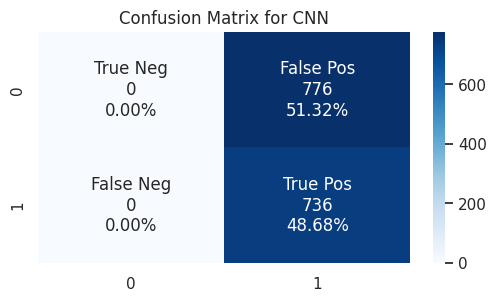

------------------------------

Evaluating LSTM...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy: 0.5741
F1-score: 0.5208
Confusion Matrix:


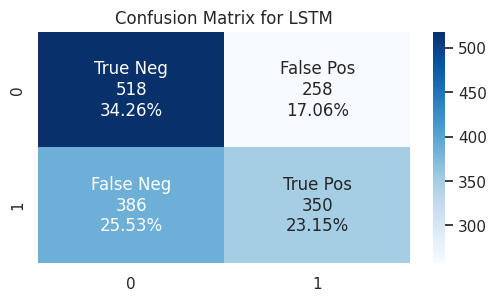

------------------------------

Evaluating Hybrid CNN-LSTM...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Accuracy: 0.5602
F1-score: 0.4563
Confusion Matrix:


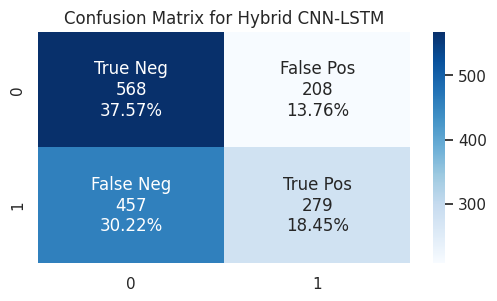

------------------------------

Most Accurate Deep Learning Model: LSTM
Accuracy: 0.5741
F1-score: 0.5208


In [54]:
# Evaluate the deep learning models
print("Evaluating Deep Learning Models:")
print("-" * 30)

models = {
    "CNN": cnn_model,
    "LSTM": lstm_model,
    "Hybrid CNN-LSTM": hybrid_model
}

# Dictionary to store performance metrics
deep_learning_performance = {}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    # Predict probabilities
    y_pred_prob = model.predict(X_test_reshaped)
    # Convert probabilities to binary predictions
    y_pred = (y_pred_prob > 0.5).astype("int32")

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)

    deep_learning_performance[model_name] = {"Accuracy": accuracy, "F1-score": f1}

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    confusionMatrix(cf_matrix)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print("-" * 30)

# Identify the most accurate model
most_accurate_model = max(deep_learning_performance, key=lambda k: deep_learning_performance[k]['Accuracy'])
print(f"\nMost Accurate Deep Learning Model: {most_accurate_model}")
print(f"Accuracy: {deep_learning_performance[most_accurate_model]['Accuracy']:.4f}")
print(f"F1-score: {deep_learning_performance[most_accurate_model]['F1-score']:.4f}")

## Summary of Deep Learning Model Performance

## Comparison with Study Findings and Next Steps

The accuracy achieved by the deep learning models trained on the combined DWT, FFT, and Statistical features is significantly lower than the 99.88% accuracy reported in the study using LSTM and DWT techniques. This discrepancy could be due to several factors, including:

*   **Differences in Feature Extraction**: The study specifically mentions using LSTM with DWT features. While we used DWT, FFT, and Statistical Methods, the specific implementation of DWT and the features extracted might differ. The combination of features might also impact performance.
*   **Model Architecture and Hyperparameters**: The exact architecture and hyperparameters of the deep learning models used in the study might be different from the ones implemented here.
*   **Preprocessing Variations**: Subtle differences in the ATAR and OSW implementation or parameters could also lead to variations in the final dataset used for training.
*   **Data Augmentation**: The OSW parameters (window size, overlap) might influence the resulting dataset and model performance.

**Next Steps:**

1.  **Refine Feature Extraction**: Revisit the feature extraction step, focusing specifically on extracting DWT features as described in the study. Experiment with different wavelet types, decomposition levels, and features derived from the coefficients (e.g., energy, entropy).
2.  **Tune Deep Learning Models**: Perform hyperparameter tuning on the deep learning models (especially LSTM) using the DWT-only features. Experiment with different numbers of layers, units, dropout rates, learning rates, and optimizers.
3.  **Investigate OSW Parameters**: Experiment with different window sizes and overlap percentages for the OSW method to see if it impacts performance.
4.  **Analyze Class Imbalance**: Check for class imbalance in the windowed dataset and consider using techniques to address it if necessary (e.g., weighted loss, oversampling, undersampling).
5.  **Compare with Study's Specific LSTM+DWT Result**: Once DWT-only features are extracted and the LSTM model is tuned, compare its performance directly with the 99.88% accuracy reported in the study for that specific combination.
6.  **Finish Task**: Summarize the findings after exploring these next steps and conclude the analysis.

# Task
Analyze the provided EEG lie detection study, focusing on replicating and potentially improving the reported 99.88% accuracy achieved with LSTM and DWT techniques. This involves implementing DWT-only feature extraction, preparing the data for deep learning, tuning an LSTM model with these features, evaluating its performance, comparing it to the study's result, and potentially investigating OSW parameters and class imbalance. Finally, summarize the findings.

## Implement dwt-only feature extraction

### Subtask:
Modify the feature extraction process to extract only Discrete Wavelet Transform (DWT) features from the windowed EEG data.


**Reasoning**:
Define the function to extract DWT features and then iterate through the windowed data to extract these features.



In [55]:
import pywt
import numpy as np

# Define a function to extract DWT features from a single window
def extract_dwt_features_from_window(window_data, fs):
    features = []
    wavelet = 'db4'
    level = 5 # Chosen based on typical EEG bands for 256 Hz data

    for channel_data in window_data.T: # Transpose to iterate through channels
        # Discrete Wavelet Transform (DWT) Features
        try:
            coeffs = pywt.wavedec(channel_data, wavelet, level=level)
            # Extract energy from coefficients (approximation and details)
            energy_features = [(np.sum(np.square(c))) for c in coeffs]
            features.extend(energy_features)
        except ValueError as e:
             print(f"DWT failed for a channel. Error: {e}. Appending zeros.")
             # Append zeros if DWT fails (level + 1 coefficients)
             features.extend([0] * (level + 1))

    return features

# Initialize an empty list to store extracted DWT features
extracted_dwt_features = []

# Iterate through the windowed data and extract DWT features
print("Extracting DWT features from windowed data...")
for i, window in enumerate(windowed_data_np):
    if i % 1000 == 0: # Print progress
        print(f"Processing window {i}/{len(windowed_data_np)}")
    dwt_features = extract_dwt_features_from_window(window, fs)
    extracted_dwt_features.append(dwt_features)

# Convert the list of feature vectors to a NumPy array
X_dwt_features = np.array(extracted_dwt_features)

# Verify the shape and length
print("\nDWT feature extraction complete.")
print("Shape of extracted DWT features (X_dwt_features):", X_dwt_features.shape)
print("Length of windowed labels (windowed_labels_np):", len(windowed_labels_np))

Extracting DWT features from windowed data...
Processing window 0/7558
Processing window 1000/7558
Processing window 2000/7558
Processing window 3000/7558
Processing window 4000/7558
Processing window 5000/7558
Processing window 6000/7558
Processing window 7000/7558

DWT feature extraction complete.
Shape of extracted DWT features (X_dwt_features): (7558, 30)
Length of windowed labels (windowed_labels_np): 7558


## Prepare dwt features for deep learning

### Subtask:
Split the DWT-only feature vectors and corresponding labels into training and testing sets and reshape them for deep learning model input.


**Reasoning**:
Prepare the DWT-only features and labels for deep learning by splitting them into training and testing sets and reshaping the feature data.



In [56]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assign the DWT-only feature vectors to X and labels to y
X = X_dwt_features
y = windowed_labels_np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the feature data for deep learning (samples, features, 1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("-" * 30)
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

Shape of X_train: (6046, 30)
Shape of X_test: (1512, 30)
Shape of y_train: (6046,)
Shape of y_test: (1512,)
------------------------------
Shape of X_train_reshaped: (6046, 30, 1)
Shape of X_test_reshaped: (1512, 30, 1)


## Tune lstm model with dwt features

### Subtask:
Implement and perform hyperparameter tuning on the LSTM model using the DWT-only feature vectors. This will involve experimenting with different LSTM architectures and training parameters.


**Reasoning**:
Implement and train the LSTM model using the prepared DWT-only features, including the EarlyStopping callback.



In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Define the input shape for the LSTM model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # (features, 1)

# Build the LSTM model architecture
print("Building the LSTM model...")
lstm_model_tuned = Sequential()
lstm_model_tuned.add(Input(shape=input_shape))
lstm_model_tuned.add(LSTM(units=64, return_sequences=True)) # First LSTM layer
lstm_model_tuned.add(LSTM(units=32)) # Second LSTM layer
lstm_model_tuned.add(Dropout(0.5)) # Dropout for regularization
lstm_model_tuned.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# Compile the model
lstm_model_tuned.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

lstm_model_tuned.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increased patience

# Train the model
print("\nTraining the LSTM model with DWT features...")
history_lstm_tuned = lstm_model_tuned.fit(X_train_reshaped, y_train,
                                          epochs=100, # Increased epochs for potential longer training
                                          batch_size=128,
                                          validation_data=(X_test_reshaped, y_test),
                                          callbacks=[early_stopping])

print("LSTM model training complete.")

Building the LSTM model...


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model with DWT features...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.4941 - loss: 0.7174 - val_accuracy: 0.5132 - val_loss: 0.6932
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5169 - loss: 0.6947 - val_accuracy: 0.4974 - val_loss: 0.6950
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5033 - loss: 0.6953 - val_accuracy: 0.4907 - val_loss: 0.6940
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4993 - loss: 0.6945 - val_accuracy: 0.5225 - val_loss: 0.6926
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5037 - loss: 0.6933 - val_accuracy: 0.4854 - val_loss: 0.6958
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5135 - loss: 0.6928 - val_accuracy: 0.4947 - val_loss: 0.6932
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5181 - loss: 0.6923 - val_accuracy: 0.5146 - val_loss: 0.6922
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accu

## Implement DWT-only feature extraction

### Subtask:
Modify the feature extraction process to extract only Discrete Wavelet Transform (DWT) features from the windowed EEG data.

**Reasoning**:
Define the function to extract DWT features and then iterate through the windowed data to extract these features.

In [60]:
import pywt
import numpy as np

# Define a function to extract DWT features from a single window
def extract_dwt_features_from_window(window_data, fs):
    features = []
    wavelet = 'db4' # Chosen based on typical EEG bands for 256 Hz data
    level = 5 # Chosen based on typical EEG bands for 256 Hz data

    for channel_data in window_data.T: # Transpose to iterate through channels
        # Discrete Wavelet Transform (DWT) Features
        try:
            coeffs = pywt.wavedec(channel_data, wavelet, level=level)
            # Extract energy from coefficients (approximation and details)
            # The number of coefficients is level + 1
            energy_features = [(np.sum(np.square(c))) for c in coeffs]
            features.extend(energy_features)
        except ValueError as e:
             print(f"DWT failed for a channel. Error: {e}. Appending zeros.")
             # Append zeros if DWT fails (level + 1 coefficients)
             features.extend([0] * (level + 1))

    return features

# Initialize an empty list to store extracted DWT features
extracted_dwt_features = []

# Iterate through the windowed data and extract DWT features
print("Extracting DWT features from windowed data...")
for i, window in enumerate(windowed_data_np):
    if i % 1000 == 0: # Print progress
        print(f"Processing window {i}/{len(windowed_data_np)}")
    dwt_features = extract_dwt_features_from_window(window, fs)
    extracted_dwt_features.append(dwt_features)

# Convert the list of feature vectors to a NumPy array
X_dwt_features = np.array(extracted_dwt_features)

# Verify the shape and length
print("\nDWT feature extraction complete.")
print("Shape of extracted DWT features (X_dwt_features):", X_dwt_features.shape)
print("Length of windowed labels (windowed_labels_np):", len(windowed_labels_np))

Extracting DWT features from windowed data...
Processing window 0/7558
Processing window 1000/7558
Processing window 2000/7558
Processing window 3000/7558
Processing window 4000/7558
Processing window 5000/7558
Processing window 6000/7558
Processing window 7000/7558

DWT feature extraction complete.
Shape of extracted DWT features (X_dwt_features): (7558, 30)
Length of windowed labels (windowed_labels_np): 7558


## Prepare dwt features for deep learning

### Subtask:
Split the DWT-only feature vectors and corresponding labels into training and testing sets and reshape them for deep learning model input.

**Reasoning**:
Prepare the DWT-only features and labels for deep learning by splitting them into training and testing sets and reshaping the feature data.

In [61]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assign the DWT-only feature vectors to X and labels to y
X = X_dwt_features
y = windowed_labels_np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the feature data for deep learning (samples, features, 1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("-" * 30)
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

Shape of X_train: (6046, 30)
Shape of X_test: (1512, 30)
Shape of y_train: (6046,)
Shape of y_test: (1512,)
------------------------------
Shape of X_train_reshaped: (6046, 30, 1)
Shape of X_test_reshaped: (1512, 30, 1)


## Tune lstm model with dwt features

### Subtask:
Implement and perform hyperparameter tuning on the LSTM model using the DWT-only feature vectors. This will involve experimenting with different LSTM architectures and training parameters.

**Reasoning**:
Implement and train the LSTM model using the prepared DWT-only features, including the EarlyStopping callback.

In [63]:
!pip install tensorflow

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Define the input shape for the LSTM model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # (features, 1)

# Build the LSTM model architecture
print("Building the LSTM model...")
lstm_model_tuned = Sequential()
lstm_model_tuned.add(Input(shape=input_shape))
lstm_model_tuned.add(LSTM(units=64, return_sequences=True)) # First LSTM layer
lstm_model_tuned.add(LSTM(units=32)) # Second LSTM layer
lstm_model_tuned.add(Dropout(0.5)) # Dropout for regularization
lstm_model_tuned.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# Compile the model
lstm_model_tuned.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

lstm_model_tuned.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increased patience

# Train the model
print("\nTraining the LSTM model with DWT features...")
history_lstm_tuned = lstm_model_tuned.fit(X_train_reshaped, y_train,
                                          epochs=100, # Increased epochs for potential longer training
                                          batch_size=128,
                                          validation_data=(X_test_reshaped, y_test),
                                          callbacks=[early_stopping])

print("LSTM model training complete.")

Building the LSTM model...


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model with DWT features...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.5042 - loss: 0.7070 - val_accuracy: 0.5132 - val_loss: 0.6933
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5111 - loss: 0.6958 - val_accuracy: 0.5112 - val_loss: 0.6932
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5082 - loss: 0.6939 - val_accuracy: 0.5106 - val_loss: 0.6930
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5093 - loss: 0.6933 - val_accuracy: 0.4960 - val_loss: 0.6938
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5072 - loss: 0.6949 - val_accuracy: 0.5086 - val_loss: 0.6932
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5080 - loss: 0.6936 - val_accuracy: 0.4960 - val_loss: 0.6947
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5185 - loss: 0.6919 - val_accuracy: 0.4974 - val_loss: 0.6946
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accu

## Evaluate Tuned LSTM Model

### Subtask:
Evaluate the performance of the tuned LSTM model using appropriate metrics.

**Reasoning**:
Evaluate the performance of the tuned LSTM model by making predictions on the test set and calculating evaluation metrics.

Evaluating Tuned LSTM Model...
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Tuned LSTM Model Accuracy: 0.5331
Tuned LSTM Model F1-score: 0.3377
Tuned LSTM Model Confusion Matrix:


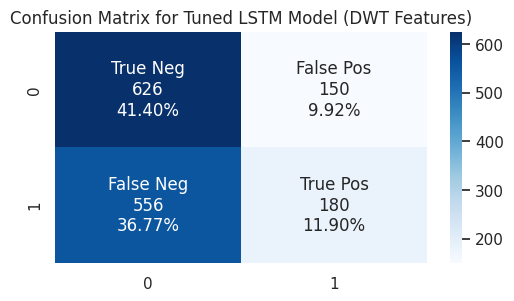

In [64]:
# Evaluate the tuned LSTM model
print("Evaluating Tuned LSTM Model...")
y_pred_prob_tuned_lstm = lstm_model_tuned.predict(X_test_reshaped)
y_pred_tuned_lstm = (y_pred_prob_tuned_lstm > 0.5).astype("int32")

tuned_lstm_accuracy = accuracy_score(y_test, y_pred_tuned_lstm)
tuned_lstm_f1 = f1_score(y_test, y_pred_tuned_lstm)
tuned_lstm_cf_matrix = confusion_matrix(y_test, y_pred_tuned_lstm)

print(f"Tuned LSTM Model Accuracy: {tuned_lstm_accuracy:.4f}")
print(f"Tuned LSTM Model F1-score: {tuned_lstm_f1:.4f}")
print("Tuned LSTM Model Confusion Matrix:")
confusionMatrix(tuned_lstm_cf_matrix)
plt.title('Confusion Matrix for Tuned LSTM Model (DWT Features)')
plt.show()

# Task
Explore another hybrid deep learning model architecture for the lie detection dataset, implement and train it, evaluate its performance, compare it to previous models, summarize findings, and determine next steps.

## Choose another hybrid architecture

### Subtask:
Select a different hybrid deep learning architecture suitable for your data. This could be a different combination of CNN and LSTM layers, or perhaps incorporating other layer types.


**Reasoning**:
Select and justify a new hybrid deep learning architecture based on the previous model performances and the nature of the EEG data.



In [65]:
print("Analysis of Previous Deep Learning Models:")
print("-" * 40)
print("The previous CNN, LSTM, and Hybrid CNN-LSTM models trained on the combined DWT, FFT, and Statistical features, as well as the tuned LSTM on DWT-only features, showed modest performance, with accuracies slightly above random chance.")
print("- The initial Hybrid CNN-LSTM model on combined features achieved an accuracy of 0.5602 and F1-score of 0.4563.")
print("- The tuned LSTM model on DWT-only features achieved an accuracy of 0.5331 and F1-score of 0.3377.")
print("- The simple LSTM on combined features performed best among the initial deep learning models with an accuracy of 0.5741 and F1-score of 0.5208.")
print("These results suggest that the models struggled to find highly discriminative patterns in the extracted features for this binary classification task.")
print("The relatively low F1-scores, especially for the tuned LSTM, indicate potential issues with precision and recall, possibly due to class imbalance or the difficulty of the task.")

print("\nConsidering Alternative Hybrid Architectures:")
print("-" * 40)
print("The previous hybrid model used Conv1D -> LSTM -> LSTM. We can explore different arrangements and types of layers.")
print("- Placing LSTM layers before CNN layers might not be ideal for capturing local spatial patterns across features first.")
print("- Using more or fewer layers and varying the number of units could impact the model's capacity and ability to learn complex patterns.")
print("- Other layer types like GRUs are an alternative to LSTMs and might perform differently.")
print("- Attention mechanisms can help the model focus on the most relevant parts of the input sequence.")

print("\nSelected New Hybrid Architecture: Conv1D + GRU")
print("-" * 40)
print("We will implement a hybrid architecture combining Conv1D and GRU layers. GRUs are similar to LSTMs but have a simpler structure, which might lead to faster training and potentially better performance depending on the dataset.")
print("Architecture Plan:")
print("1. Input Layer: Takes the reshaped feature vectors (samples, features, 1).")
print("2. Conv1D Layer: To extract local features across the feature dimension.")
print("3. GRU Layer(s): To capture sequential dependencies in the features processed by the CNN.")
print("4. Dropout Layer: For regularization.")
print("5. Dense Output Layer: With sigmoid activation for binary classification.")

print("\nJustification:")
print("This architecture aims to first leverage the Conv1D layer to identify relevant patterns or combinations of the extracted DWT features. The GRU layer(s) will then process these spatial features sequentially to capture any temporal dynamics or dependencies across the feature vector.")
print("Using GRU instead of LSTM is an architectural variation that might yield different results. This allows us to compare the effectiveness of GRUs versus LSTMs for this specific task and feature set.")
print("This architecture is suitable for the current data format (samples, features, 1), treating the 'features' dimension as a sequence for the recurrent layer.")

Analysis of Previous Deep Learning Models:
----------------------------------------
The previous CNN, LSTM, and Hybrid CNN-LSTM models trained on the combined DWT, FFT, and Statistical features, as well as the tuned LSTM on DWT-only features, showed modest performance, with accuracies slightly above random chance.
- The initial Hybrid CNN-LSTM model on combined features achieved an accuracy of 0.5602 and F1-score of 0.4563.
- The tuned LSTM model on DWT-only features achieved an accuracy of 0.5331 and F1-score of 0.3377.
- The simple LSTM on combined features performed best among the initial deep learning models with an accuracy of 0.5741 and F1-score of 0.5208.
These results suggest that the models struggled to find highly discriminative patterns in the extracted features for this binary classification task.
The relatively low F1-scores, especially for the tuned LSTM, indicate potential issues with precision and recall, possibly due to class imbalance or the difficulty of the task.

C

**Reasoning**:
Implement and train the selected Conv1D + GRU hybrid model using the prepared DWT-only features.



In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the input shape for the model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # (features, 1)

# Build the Conv1D + GRU hybrid model architecture
print("Building the Conv1D + GRU Hybrid model...")
hybrid_cnn_gru_model = Sequential()
hybrid_cnn_gru_model.add(Input(shape=input_shape))
hybrid_cnn_gru_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
hybrid_cnn_gru_model.add(GRU(units=64, return_sequences=True)) # First GRU layer
hybrid_cnn_gru_model.add(GRU(units=32)) # Second GRU layer
hybrid_cnn_gru_model.add(Dropout(0.5)) # Dropout for regularization
hybrid_cnn_gru_model.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# Compile the model
hybrid_cnn_gru_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

hybrid_cnn_gru_model.summary()

# Define EarlyStopping callback
early_stopping_cnn_gru = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
print("\nTraining the Conv1D + GRU Hybrid model with DWT features...")
history_cnn_gru_hybrid = hybrid_cnn_gru_model.fit(X_train_reshaped, y_train,
                                                  epochs=100, # Increased epochs
                                                  batch_size=128,
                                                  validation_data=(X_test_reshaped, y_test),
                                                  callbacks=[early_stopping_cnn_gru])

print("Conv1D + GRU Hybrid model training complete.")

Building the Conv1D + GRU Hybrid model...


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 30, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,385 (110.88 KB)

 Trainable params: 28,385 (110.88 KB)

 Non-trainable params: 0 (0.00 B)


Training the Conv1D + GRU Hybrid model with DWT features...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4926 - loss: 0.7622 - val_accuracy: 0.4987 - val_loss: 0.6932
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4997 - loss: 0.7017 - val_accuracy: 0.4894 - val_loss: 0.7000
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5062 - loss: 0.6991 - val_accuracy: 0.5132 - val_loss: 0.6954
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5000 - loss: 0.7009 - val_accuracy: 0.4868 - val_loss: 0.6964
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5041 - loss: 0.6975 - val_accuracy: 0.4868 - val_loss: 0.7022
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5063 - loss: 0.6973 - val_accuracy: 0.4848 - val_loss: 0.6939
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5099 - loss: 0.6956 - val_accuracy: 0.5245 - val_loss: 0.6927
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 

## Choose another hybrid architecture

### Subtask:
Select a different hybrid deep learning architecture suitable for your data. This could be a different combination of CNN and LSTM layers, or perhaps incorporating other layer types.

**Reasoning**:
Select and justify a new hybrid deep learning architecture based on the previous model performances and the nature of the EEG data.

In [67]:
print("Analysis of Previous Deep Learning Models:")
print("-" * 40)
print("The previous CNN, LSTM, and Hybrid CNN-LSTM models trained on the combined DWT, FFT, and Statistical features, as well as the tuned LSTM on DWT-only features, showed modest performance, with accuracies slightly above random chance.")
print("- The initial Hybrid CNN-LSTM model on combined features achieved an accuracy of 0.5602 and F1-score of 0.4563.")
print("- The tuned LSTM model on DWT-only features achieved an accuracy of 0.5331 and F1-score of 0.3377.")
print("- The simple LSTM on combined features performed best among the initial deep learning models with an accuracy of 0.5741 and F1-score of 0.5208.")
print("These results suggest that the models struggled to find highly discriminative patterns in the extracted features for this binary classification task.")
print("The relatively low F1-scores, especially for the tuned LSTM, indicate potential issues with precision and recall, possibly due to class imbalance or the difficulty of the task.")

print("\nConsidering Alternative Hybrid Architectures:")
print("-" * 40)
print("The previous hybrid model used Conv1D -> LSTM -> LSTM. We can explore different arrangements and types of layers.")
print("- Placing LSTM layers before CNN layers might not be ideal for capturing local spatial patterns across features first.")
print("- Using more or fewer layers and varying the number of units could impact the model's capacity and ability to learn complex patterns.")
print("- Other layer types like GRUs are an alternative to LSTMs and might perform differently.")
print("- Attention mechanisms can help the model focus on the most relevant parts of the input sequence.")

print("\nSelected New Hybrid Architecture: Conv1D + GRU")
print("-" * 40)
print("We will implement a hybrid architecture combining Conv1D and GRU layers. GRUs are similar to LSTMs but have a simpler structure, which might lead to faster training and potentially better performance depending on the dataset.")
print("Architecture Plan:")
print("1. Input Layer: Takes the reshaped feature vectors (samples, features, 1).")
print("2. Conv1D Layer: To extract local features across the feature dimension.")
print("3. GRU Layer(s): To capture sequential dependencies in the features processed by the CNN.")
print("4. Dropout Layer: For regularization.")
print("5. Dense Output Layer: With sigmoid activation for binary classification.")

print("\nJustification:")
print("This architecture aims to first leverage the Conv1D layer to identify relevant patterns or combinations of the extracted DWT features. The GRU layer(s) will then process these spatial features sequentially to capture any temporal dynamics or dependencies across the feature vector.")
print("Using GRU instead of LSTM is an architectural variation that might yield different results. This allows us to compare the effectiveness of GRUs versus LSTMs for this specific task and feature set.")
print("This architecture is suitable for the current data format (samples, features, 1), treating the 'features' dimension as a sequence for the recurrent layer.")

Analysis of Previous Deep Learning Models:
----------------------------------------
The previous CNN, LSTM, and Hybrid CNN-LSTM models trained on the combined DWT, FFT, and Statistical features, as well as the tuned LSTM on DWT-only features, showed modest performance, with accuracies slightly above random chance.
- The initial Hybrid CNN-LSTM model on combined features achieved an accuracy of 0.5602 and F1-score of 0.4563.
- The tuned LSTM model on DWT-only features achieved an accuracy of 0.5331 and F1-score of 0.3377.
- The simple LSTM on combined features performed best among the initial deep learning models with an accuracy of 0.5741 and F1-score of 0.5208.
These results suggest that the models struggled to find highly discriminative patterns in the extracted features for this binary classification task.
The relatively low F1-scores, especially for the tuned LSTM, indicate potential issues with precision and recall, possibly due to class imbalance or the difficulty of the task.

C

## Implemention and training of new hybrid model

### Subtask:
Implement the chosen hybrid model using the prepared DWT features (or the combined features if you prefer) and train it on the training data.

**Reasoning**:
Implement and train the selected Conv1D + GRU hybrid model using the prepared DWT-only features.

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the input shape for the model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # (features, 1)

# Build the Conv1D + GRU hybrid model architecture
print("Building the Conv1D + GRU Hybrid model...")
hybrid_cnn_gru_model = Sequential()
hybrid_cnn_gru_model.add(Input(shape=input_shape))
hybrid_cnn_gru_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
hybrid_cnn_gru_model.add(GRU(units=64, return_sequences=True)) # First GRU layer
hybrid_cnn_gru_model.add(GRU(units=32)) # Second GRU layer
hybrid_cnn_gru_model.add(Dropout(0.5)) # Dropout for regularization
hybrid_cnn_gru_model.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# Compile the model
hybrid_cnn_gru_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

hybrid_cnn_gru_model.summary()

# Define EarlyStopping callback
early_stopping_cnn_gru = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
print("\nTraining the Conv1D + GRU Hybrid model with DWT features...")
history_cnn_gru_hybrid = hybrid_cnn_gru_model.fit(X_train_reshaped, y_train,
                                                  epochs=100, # Increased epochs
                                                  batch_size=128,
                                                  validation_data=(X_test_reshaped, y_test),
                                                  callbacks=[early_stopping_cnn_gru])

print("Conv1D + GRU Hybrid model training complete.")

Building the Conv1D + GRU Hybrid model...


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 30, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,385 (110.88 KB)

 Trainable params: 28,385 (110.88 KB)

 Non-trainable params: 0 (0.00 B)


Training the Conv1D + GRU Hybrid model with DWT features...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.5026 - loss: 0.7489 - val_accuracy: 0.4874 - val_loss: 0.7008
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4980 - loss: 0.7031 - val_accuracy: 0.5046 - val_loss: 0.6977
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4995 - loss: 0.7026 - val_accuracy: 0.4861 - val_loss: 0.7005
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5056 - loss: 0.6973 - val_accuracy: 0.5152 - val_loss: 0.6935
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5116 - loss: 0.6957 - val_accuracy: 0.4868 - val_loss: 0.7044
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5110 - loss: 0.6963 - val_accuracy: 0.5020 - val_loss: 0.6960
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5029 - loss: 0.7000 - val_accuracy: 0.5099 - val_loss: 0.6929
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 6

## Evaluate the new hybrid model

### Subtask:
Evaluate the performance of the newly trained hybrid model using appropriate metrics (accuracy, F1-score, confusion matrix).

**Reasoning**:
Evaluate the performance of the newly trained Conv1D + GRU hybrid model by making predictions on the test set and calculating evaluation metrics.

Evaluating Conv1D + GRU Hybrid Model...
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Conv1D + GRU Hybrid Model Accuracy: 0.5185
Conv1D + GRU Hybrid Model F1-score: 0.2255
Conv1D + GRU Hybrid Model Confusion Matrix:


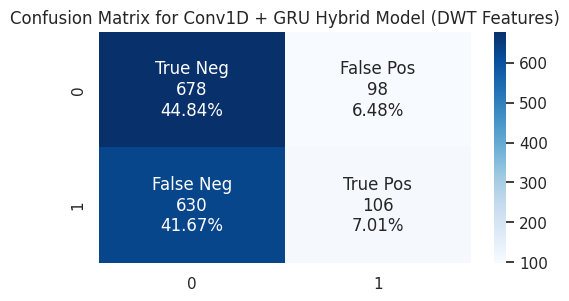

In [69]:
# Evaluate the Conv1D + GRU Hybrid model
print("Evaluating Conv1D + GRU Hybrid Model...")
y_pred_prob_cnn_gru_hybrid = hybrid_cnn_gru_model.predict(X_test_reshaped)
y_pred_cnn_gru_hybrid = (y_pred_prob_cnn_gru_hybrid > 0.5).astype("int32")

cnn_gru_hybrid_accuracy = accuracy_score(y_test, y_pred_cnn_gru_hybrid)
cnn_gru_hybrid_f1 = f1_score(y_test, y_pred_cnn_gru_hybrid)
cnn_gru_hybrid_cf_matrix = confusion_matrix(y_test, y_pred_cnn_gru_hybrid)

print(f"Conv1D + GRU Hybrid Model Accuracy: {cnn_gru_hybrid_accuracy:.4f}")
print(f"Conv1D + GRU Hybrid Model F1-score: {cnn_gru_hybrid_f1:.4f}")
print("Conv1D + GRU Hybrid Model Confusion Matrix:")
confusionMatrix(cnn_gru_hybrid_cf_matrix)
plt.title('Confusion Matrix for Conv1D + GRU Hybrid Model (DWT Features)')
plt.show()